In [1]:
import importlib.util
import sys
from pathlib import Path
custom_rqa_path = Path("RQA-and-mrDMD") / "CustomRQA.py"

spec = importlib.util.spec_from_file_location("CustomRQA", str(custom_rqa_path))

CustomRQA = importlib.util.module_from_spec(spec)

spec.loader.exec_module(CustomRQA)

sys.modules["CustomRQA"] = CustomRQA



truncate_path = Path("RQA-and-mrDMD") / "truncate.py"

spec = importlib.util.spec_from_file_location("truncate", str(truncate_path))

truncate = importlib.util.module_from_spec(spec)

spec.loader.exec_module(truncate)

sys.modules["truncate"] = truncate



In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.integrate import odeint
%pip install pydmd
%pip install statsmodels
from pydmd import DMD, BOPDMD, MrDMD
from pydmd.plotter import plot_eigs, plot_summary
from pydmd.preprocessing import hankel_preprocessing
import warnings
warnings.filterwarnings('ignore')
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
import CustomRQA as rqa
import truncate as tr

url = 'RQA-and-mrDMD/SeaSurfaceTemp/Data/time.npy'
time = np.load(url)

url = 'RQA-and-mrDMD/SeaSurfaceTemp/Data/sst_raw.npy'
sst_raw = np.load(url)


url = 'RQA-and-mrDMD/SeaSurfaceTemp/Data/sst.npy'
flat = np.load(url)

url = 'RQA-and-mrDMD/SeaSurfaceTemp/Data/lat.npy'
lat = np.load(url)


url = 'RQA-and-mrDMD/SeaSurfaceTemp/Data/lon.npy'
lon = np.load(url)


Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [3]:
X = flat
print(X.shape)

(64800, 1590)


In [4]:
sub_dmd = DMD(svd_rank=0.75)
l=9
# X = X[:,286:]
mrdmd = MrDMD(sub_dmd, max_level=l, max_cycles=1)
mrdmd.fit(X)


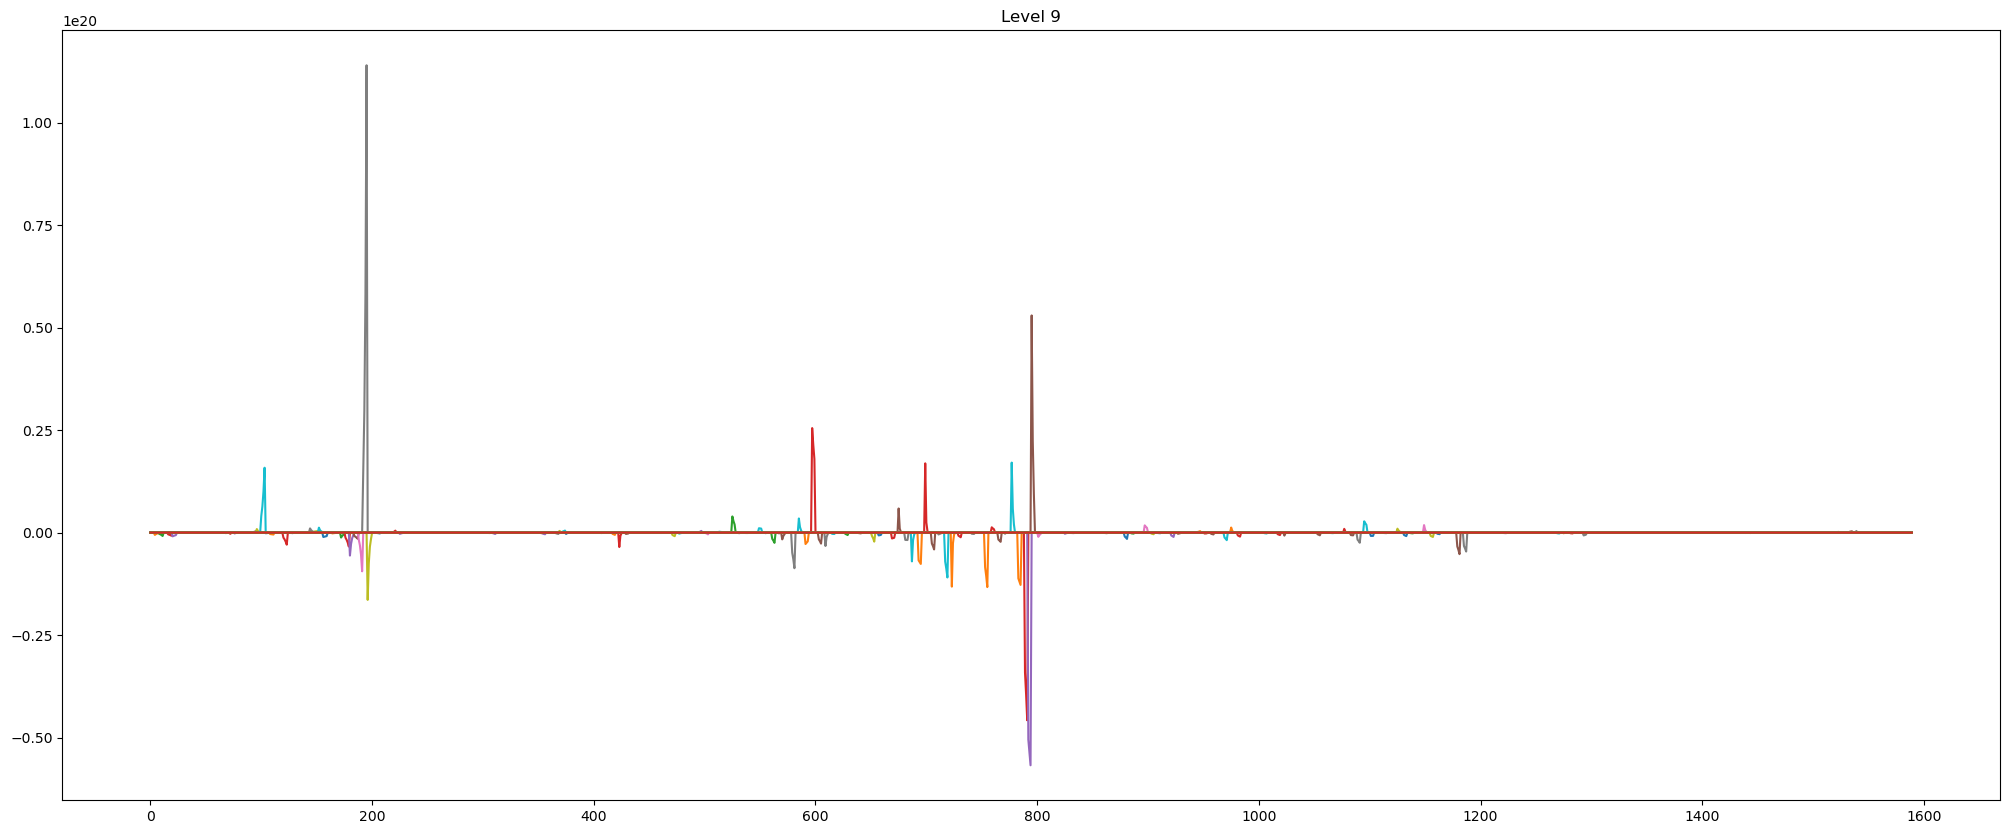

In [5]:
l = 9
last_dynamics = mrdmd.partial_dynamics(level=l)
last_modes =  mrdmd.partial_modes(level=l)
last_eigs =  mrdmd.partial_eigs(level=l)
plt.figure(figsize=(25,10))
for i in range(last_dynamics.shape[0]):
    plt.plot(last_dynamics[i])
plt.title(f'Level {l}')
plt.show()

In [6]:
df_dynamics = tr.correlation_truncate(last_dynamics.T, threshold = 0.90)
all_vectors_new = df_dynamics.to_numpy()

In [7]:
print(all_vectors_new.shape)
all_vectors = StandardScaler().fit_transform(all_vectors_new)
p=10

(1590, 444)


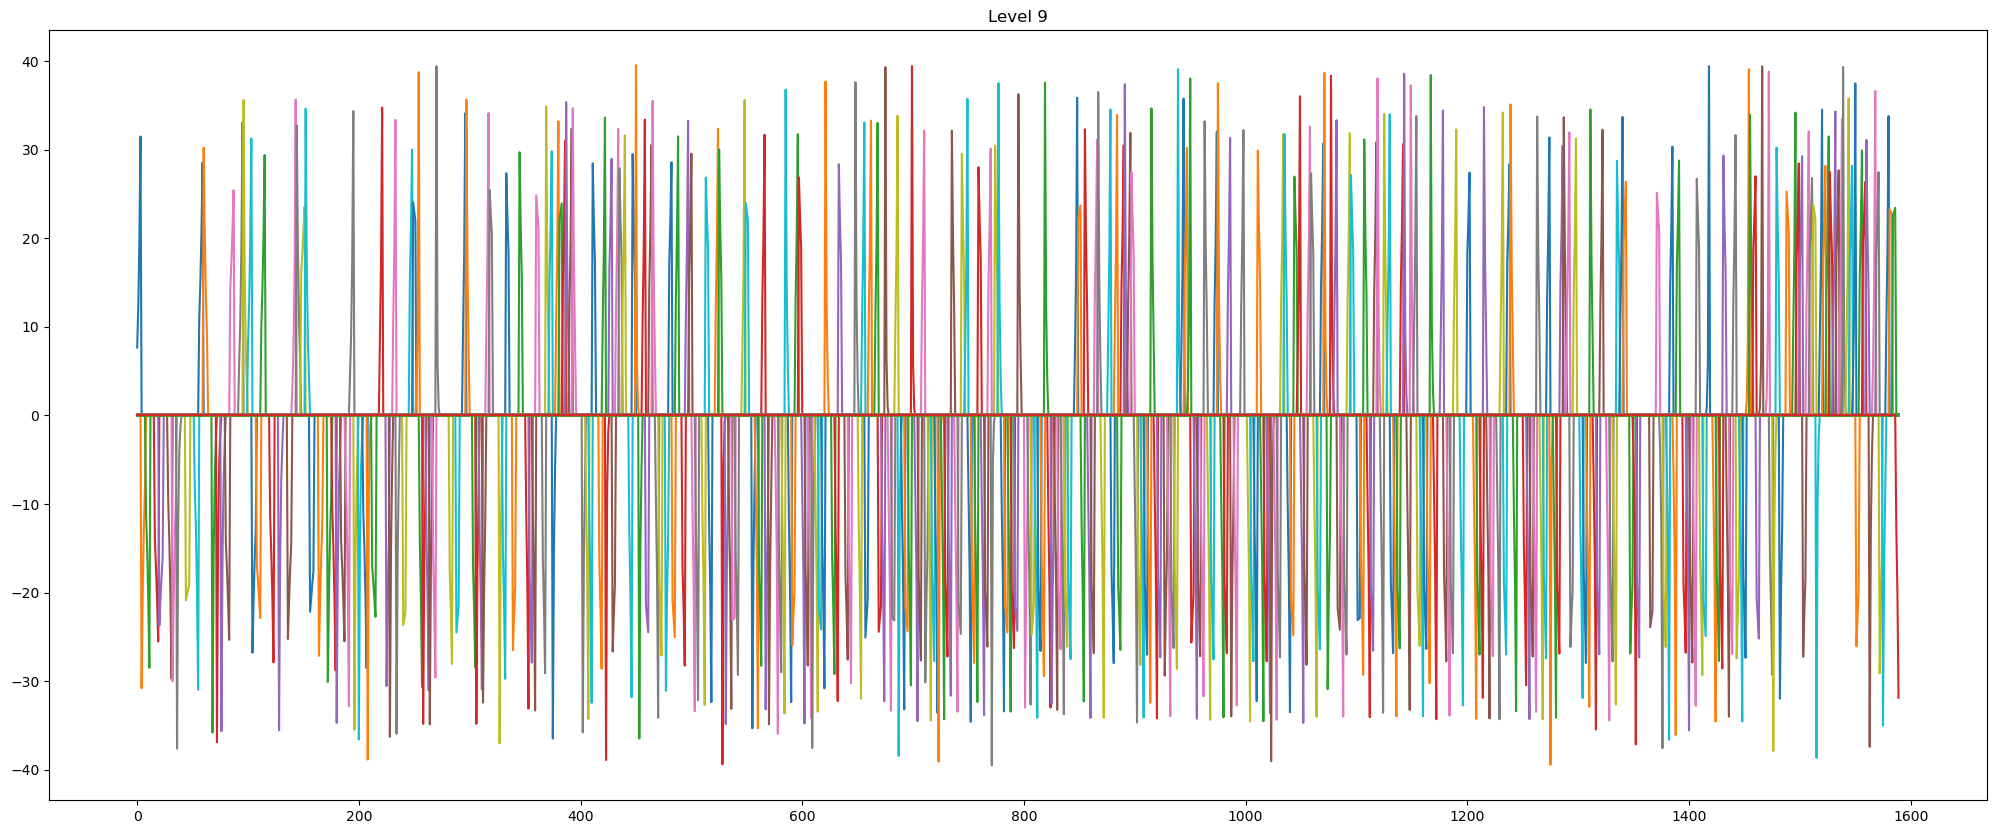

In [8]:
plt.figure(figsize=(25,10))
for i in range(all_vectors.shape[1]):
    plt.plot(all_vectors[:,i])
plt.title(f'Level {l}')
plt.show()

epsilon = 14.154


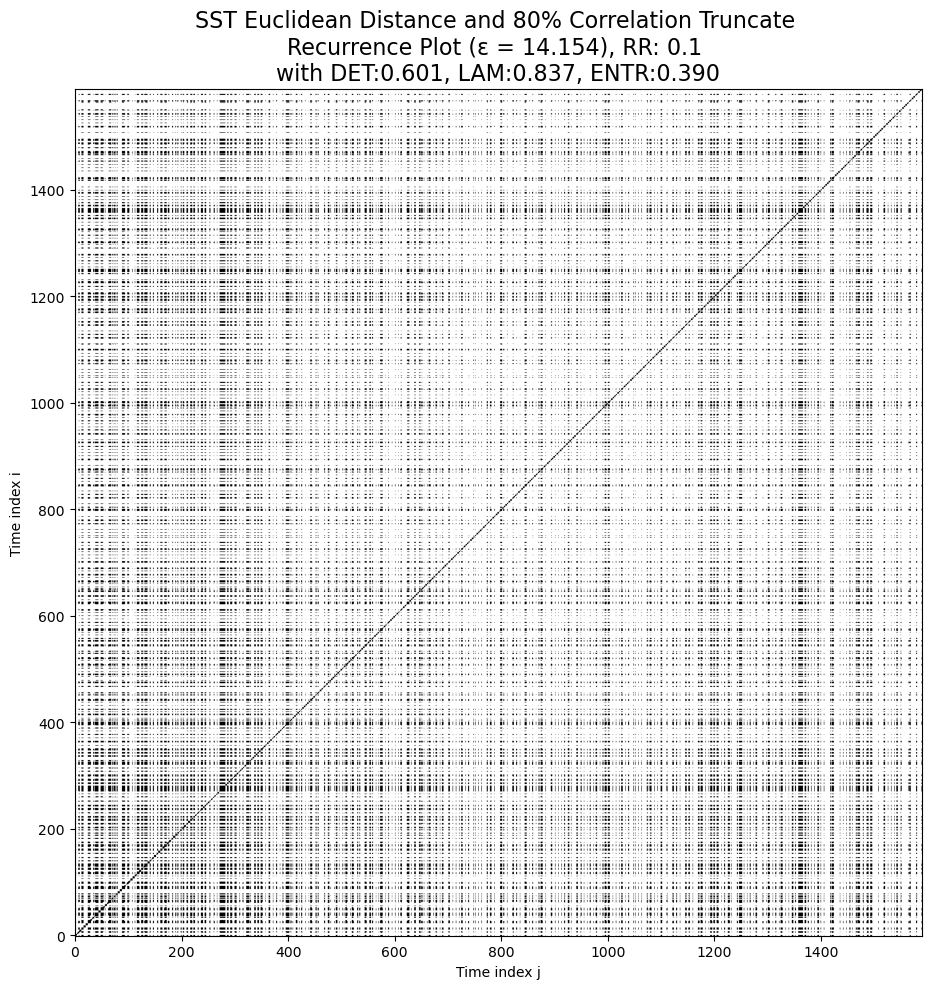

In [9]:
metrics = rqa.RecurrencePlot(all_vectors, percent=p, metric ='euclidean', globalEpsilon=True, Title = 'SST Euclidean Distance and 80% Correlation Truncate',lines = False)

(64800, 1590)


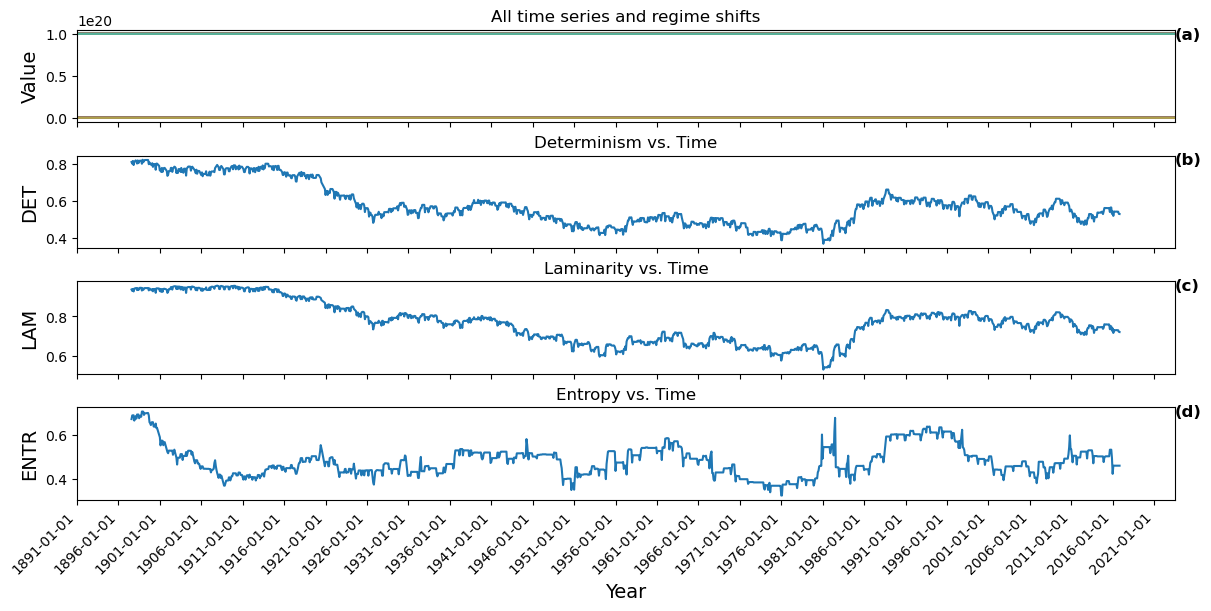

In [10]:
dt = 1
window_size = int(0.1 * all_vectors.shape[0])

times, DETS, LAMS, ENTRS = rqa.sliding_window_rqa(
    all_vectors, p, metric='euclidean', q=1,
    window_size=window_size, step=1,
    l_min=2, v_min=2, globalEpsilon=True
)

real_times  = times * dt
total_time  = X.shape[1] * dt
time_axis   = np.arange(X.shape[1])

start_year = 1891
end_year   = 2023
tick_years = np.arange(start_year, end_year+1, 5)
tick_positions = (tick_years - start_year) * 12

fig, axes = plt.subplots(4, 1, sharex=True, figsize=(12, 6), constrained_layout=True)
labels = ['(a)', '(b)', '(c)', '(d)']

print(X.shape)
for j in range(X.shape[0]):
    axes[0].plot(time_axis, X[j], alpha=0.6)
axes[0].set_ylabel('Value', fontsize=14)
axes[0].set_title('All time series and regime shifts', fontsize=12)
axes[0].text(1, 0.9, labels[0], transform=axes[0].transAxes, fontsize=12, fontweight='bold')

axes[1].plot(real_times, DETS, label='DET')
axes[1].set_ylabel('DET', fontsize=14)
axes[1].set_title('Determinism vs. Time', fontsize=12)
axes[1].text(1, 0.9, labels[1], transform=axes[1].transAxes, fontsize=12, fontweight='bold')

axes[2].plot(real_times, LAMS, label='LAM')
axes[2].set_ylabel('LAM', fontsize=14)
axes[2].set_title('Laminarity vs. Time', fontsize=12)
axes[2].text(1, 0.9, labels[2], transform=axes[2].transAxes, fontsize=12, fontweight='bold')

axes[3].plot(real_times, ENTRS, label='ENTR')
axes[3].set_ylabel('ENTR', fontsize=14)
axes[3].set_title('Entropy vs. Time', fontsize=12)
axes[3].text(1, 0.9, labels[3], transform=axes[3].transAxes, fontsize=12, fontweight='bold')

axes[3].set_xlabel('Year', fontsize=14)
axes[3].set_xlim(0, total_time)
axes[3].set_xticks(tick_positions)
axes[3].set_xticklabels([f'{yr}-01-01' for yr in tick_years], rotation=45, ha='right')

plt.show()

In [11]:
start_time_snapshot = 0 # 1940
start_year = 1890
end_year   = 2023


tick_years = np.arange(start_year, end_year+1, 5)
tick_positions = (tick_years - start_year) * 12
# window_size = 72
window_size = int(0.1 * (1590-600))


(1590, 180, 360)
5.5
210.5
(1590, 11, 51)
(561, 1590)


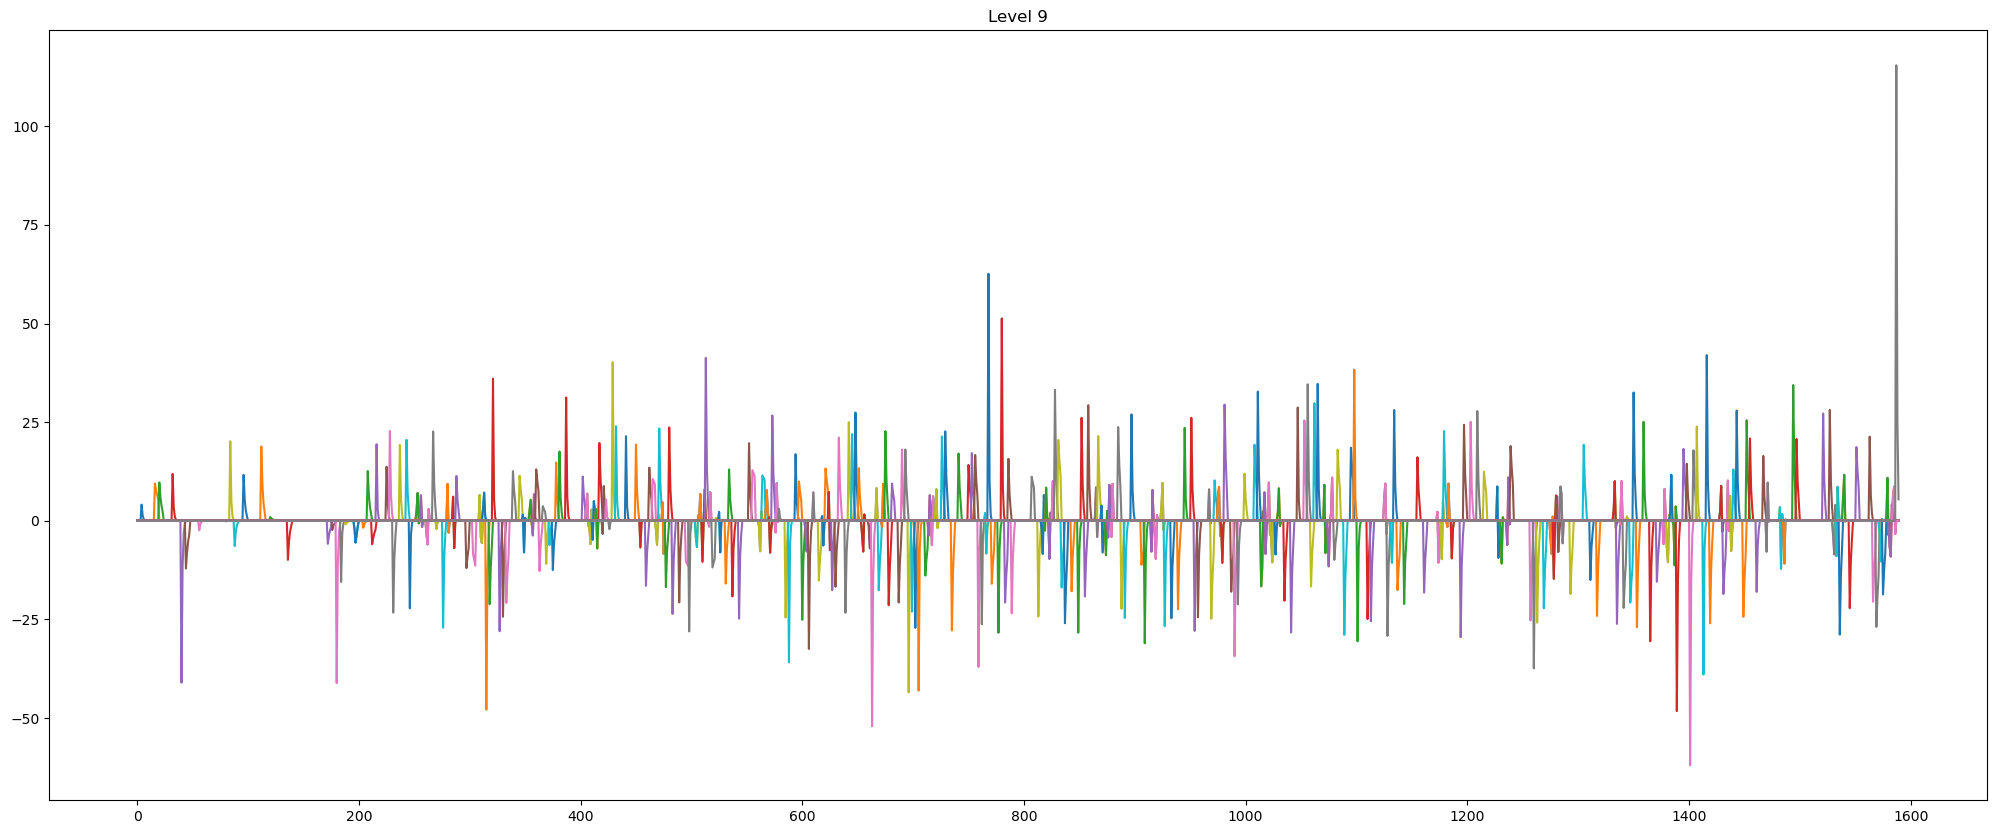

(1590, 332)


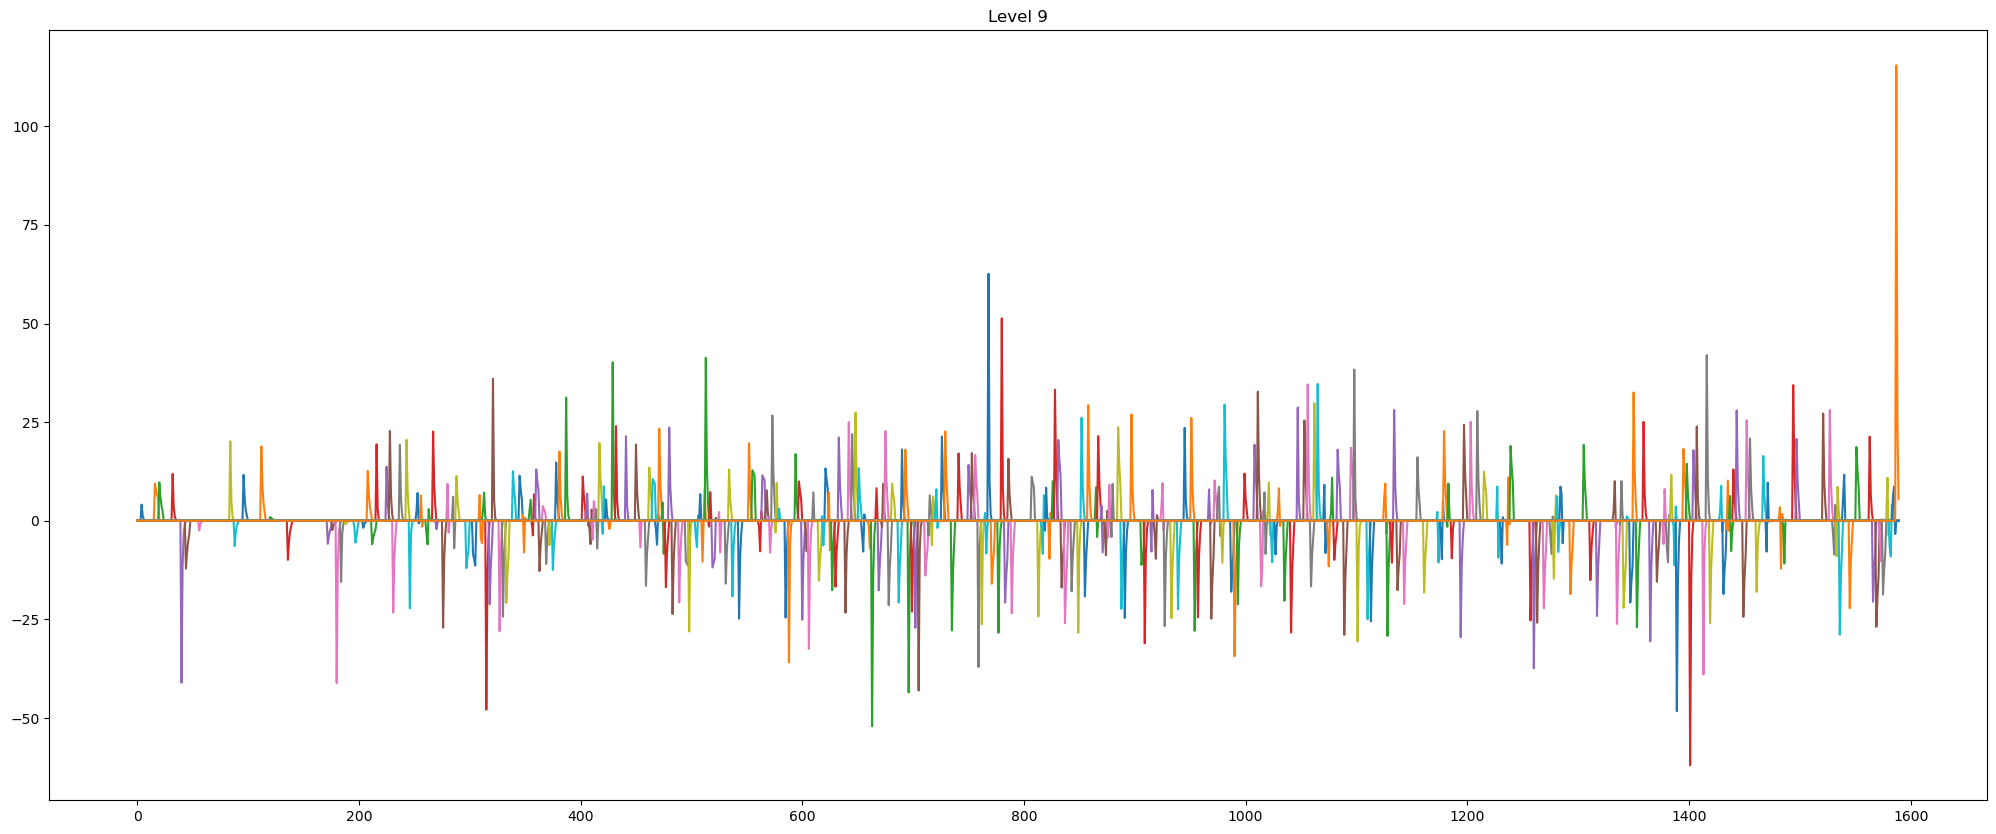

epsilon = 0.000


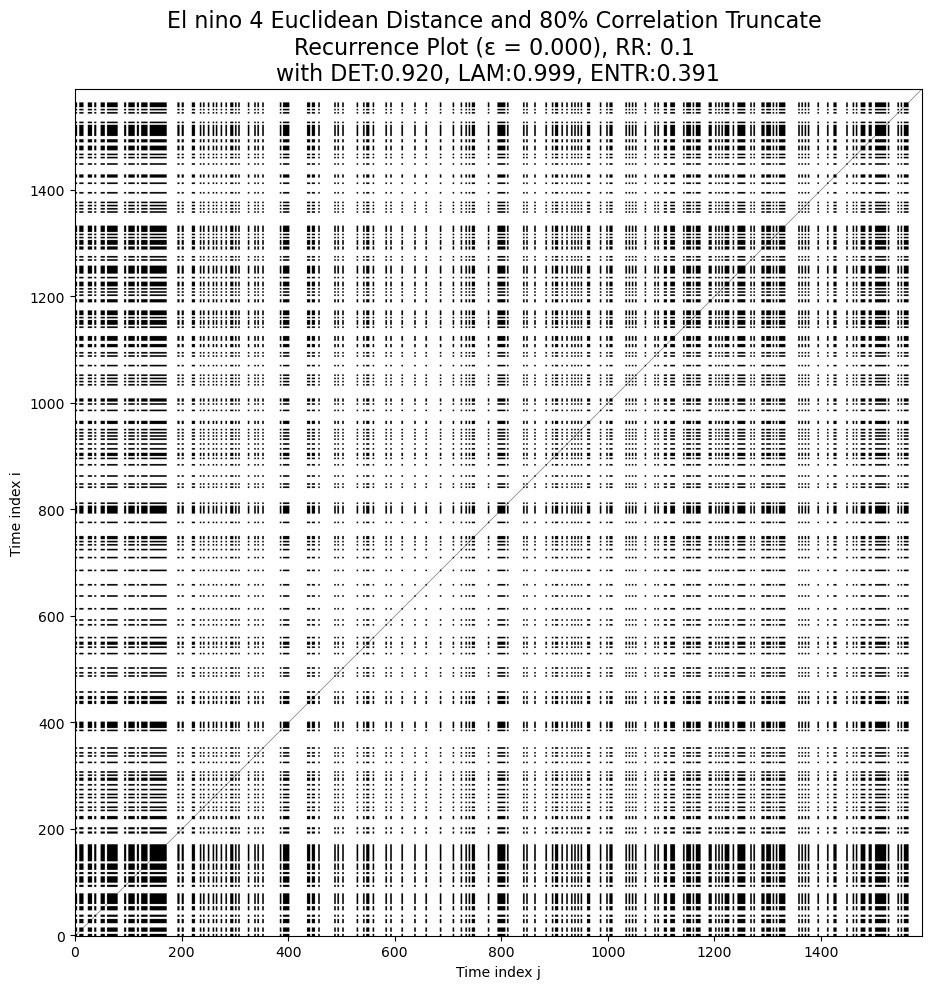

(561, 1590)


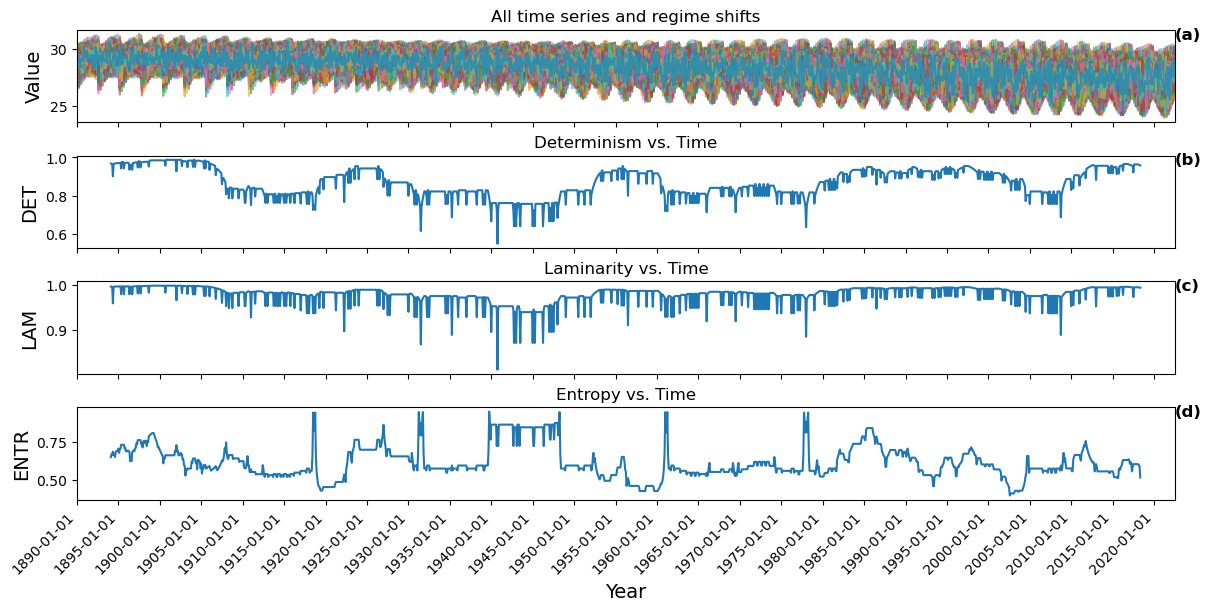

In [12]:
print(sst_raw.shape)
print(lat[84])
print(lon[210])
el_nino_4 = sst_raw[start_time_snapshot:, 84:95 , 159:210] 

print(el_nino_4.shape)
el_nino_4 = el_nino_4.T
el_nino_4 = (el_nino_4.reshape(1590-start_time_snapshot, -1).T)
print(el_nino_4.shape)

sub_dmd = DMD(svd_rank=0.75)
l=9
# X = X[:,286:]
mrdmd = MrDMD(sub_dmd, max_level=l, max_cycles=1)
mrdmd.fit(el_nino_4)

last_dynamics = mrdmd.partial_dynamics(level=l)
last_modes =  mrdmd.partial_modes(level=l)
last_eigs =  mrdmd.partial_eigs(level=l)
plt.figure(figsize=(25,10))
for i in range(last_dynamics.shape[0]):
    plt.plot(last_dynamics[i])
plt.title(f'Level {l}')
plt.show()

df_dynamics = tr.correlation_truncate(last_dynamics.T, threshold = 0.80)
all_vectors_new = df_dynamics.to_numpy()

print(all_vectors_new.shape)
all_vectors = (all_vectors_new.real)
p=10
plt.figure(figsize=(25,10))
for i in range(all_vectors.shape[1]):
    plt.plot(all_vectors[:,i])
plt.title(f'Level {l}')
plt.show()
metrics = rqa.RecurrencePlot(all_vectors, percent=p, metric ='euclidean', globalEpsilon=True, Title = 'El nino 4 Euclidean Distance and 80% Correlation Truncate',lines = False)
dt = 1

times, DETS, LAMS, ENTRS = rqa.sliding_window_rqa(
    all_vectors, p, metric='euclidean', q=1,
    window_size=window_size, step=1,
    l_min=2, v_min=2, globalEpsilon=True
)

real_times  = times * dt
total_time  = el_nino_4.shape[1] * dt
time_axis   = np.arange(el_nino_4.shape[1])


fig, axes = plt.subplots(4, 1, sharex=True, figsize=(12, 6), constrained_layout=True)
labels = ['(a)', '(b)', '(c)', '(d)']

print(el_nino_4.shape)
for j in range(el_nino_4.shape[0]):
    axes[0].plot(time_axis, el_nino_4[j], alpha=0.6)
axes[0].set_ylabel('Value', fontsize=14)
axes[0].set_title('All time series and regime shifts', fontsize=12)
axes[0].text(1, 0.9, labels[0], transform=axes[0].transAxes, fontsize=12, fontweight='bold')

axes[1].plot(real_times, DETS, label='DET')
axes[1].set_ylabel('DET', fontsize=14)
axes[1].set_title('Determinism vs. Time', fontsize=12)
axes[1].text(1, 0.9, labels[1], transform=axes[1].transAxes, fontsize=12, fontweight='bold')

axes[2].plot(real_times, LAMS, label='LAM')
axes[2].set_ylabel('LAM', fontsize=14)
axes[2].set_title('Laminarity vs. Time', fontsize=12)
axes[2].text(1, 0.9, labels[2], transform=axes[2].transAxes, fontsize=12, fontweight='bold')

axes[3].plot(real_times, ENTRS, label='ENTR')
axes[3].set_ylabel('ENTR', fontsize=14)
axes[3].set_title('Entropy vs. Time', fontsize=12)
axes[3].text(1, 0.9, labels[3], transform=axes[3].transAxes, fontsize=12, fontweight='bold')

axes[3].set_xlabel('Year', fontsize=14)
axes[3].set_xlim(0, total_time)
axes[3].set_xticks(tick_positions)
axes[3].set_xticklabels([f'{yr}-01-01' for yr in tick_years], rotation=45, ha='right')

plt.show()

(1590, 180, 360)
5.5
210.5
(1590, 11, 62)
(682, 1590)


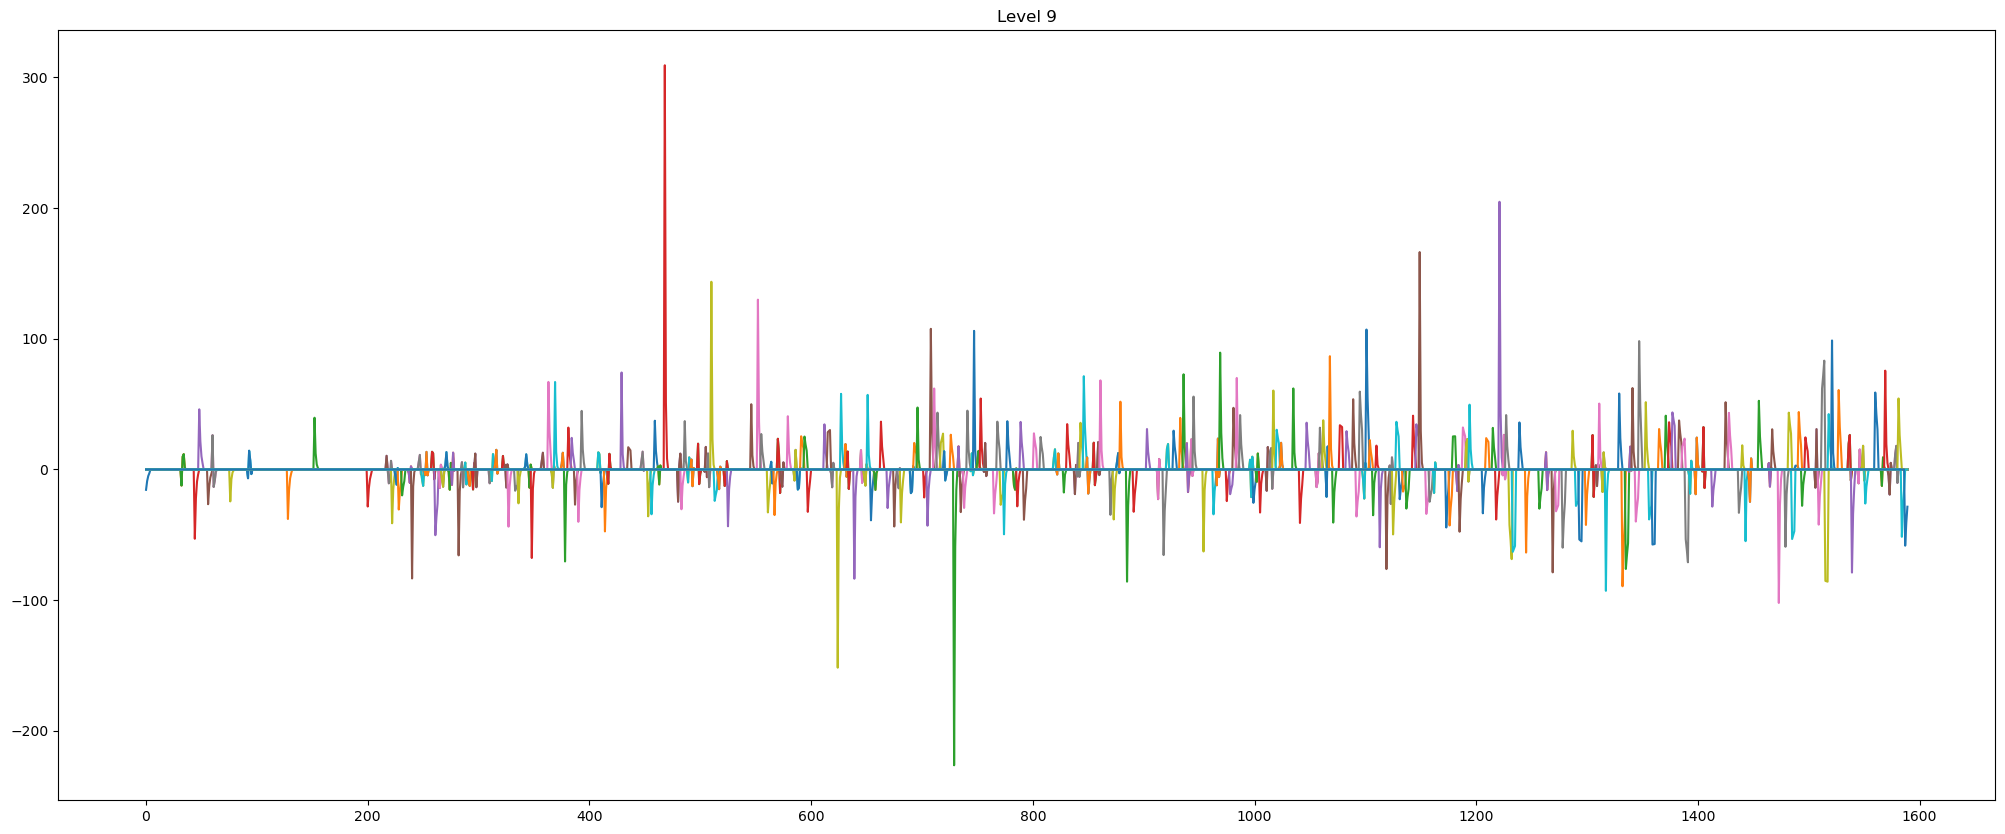

(1590, 316)


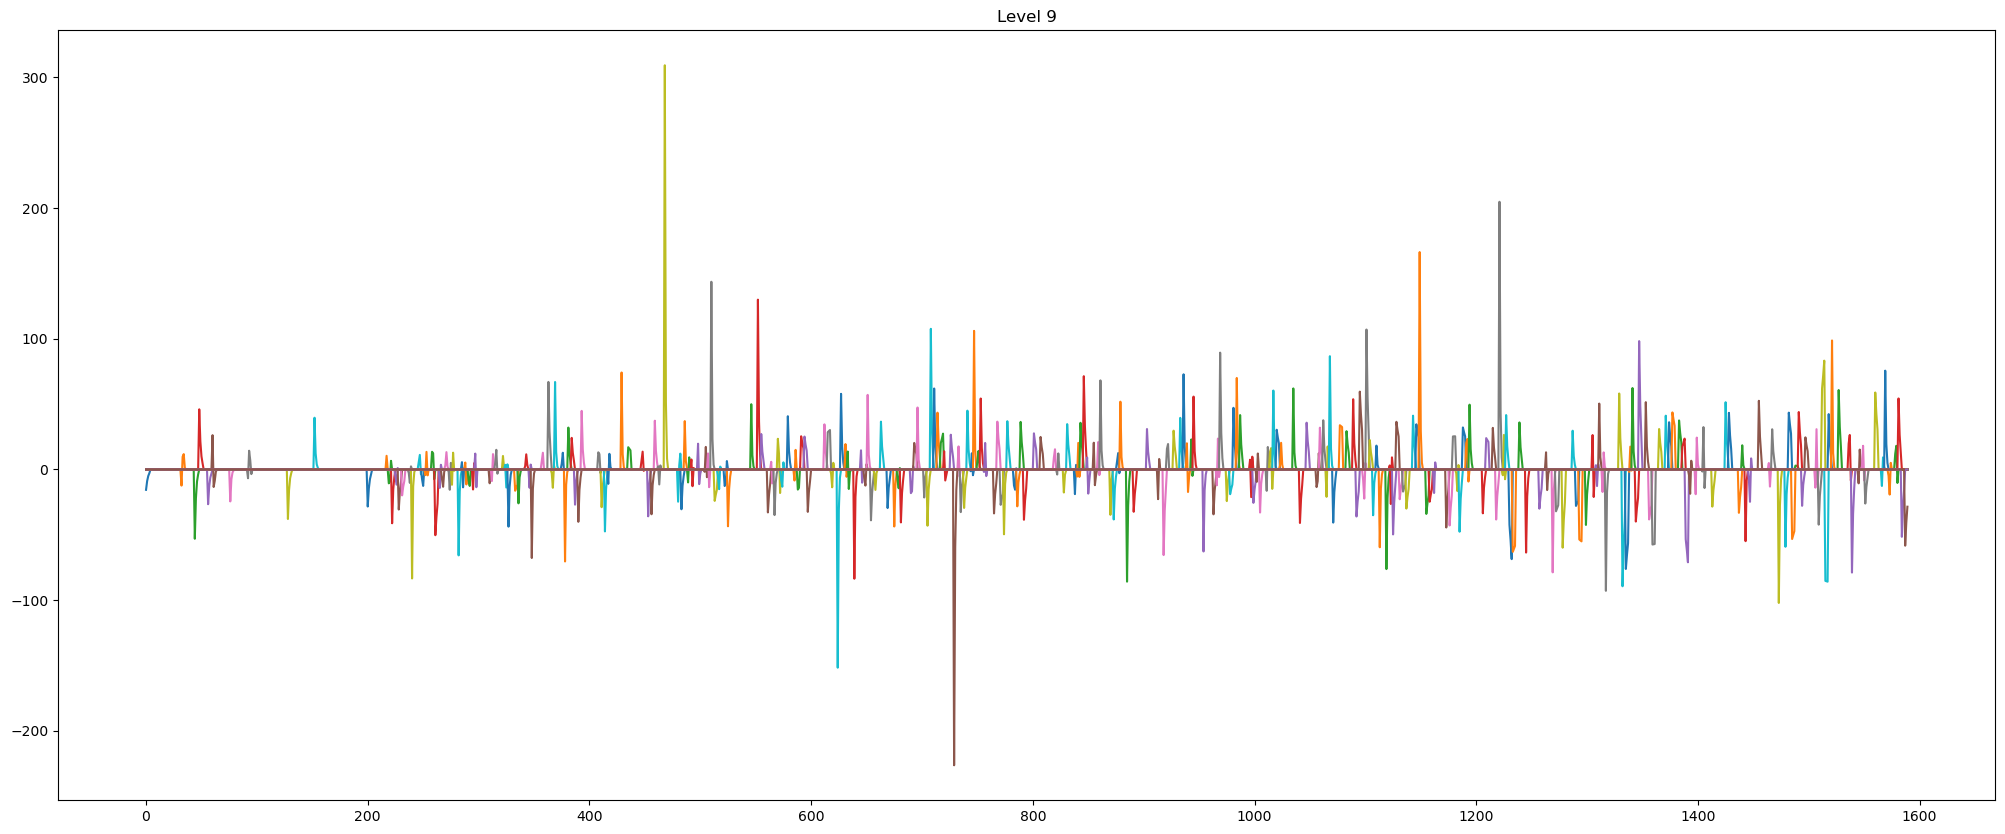

epsilon = 0.000


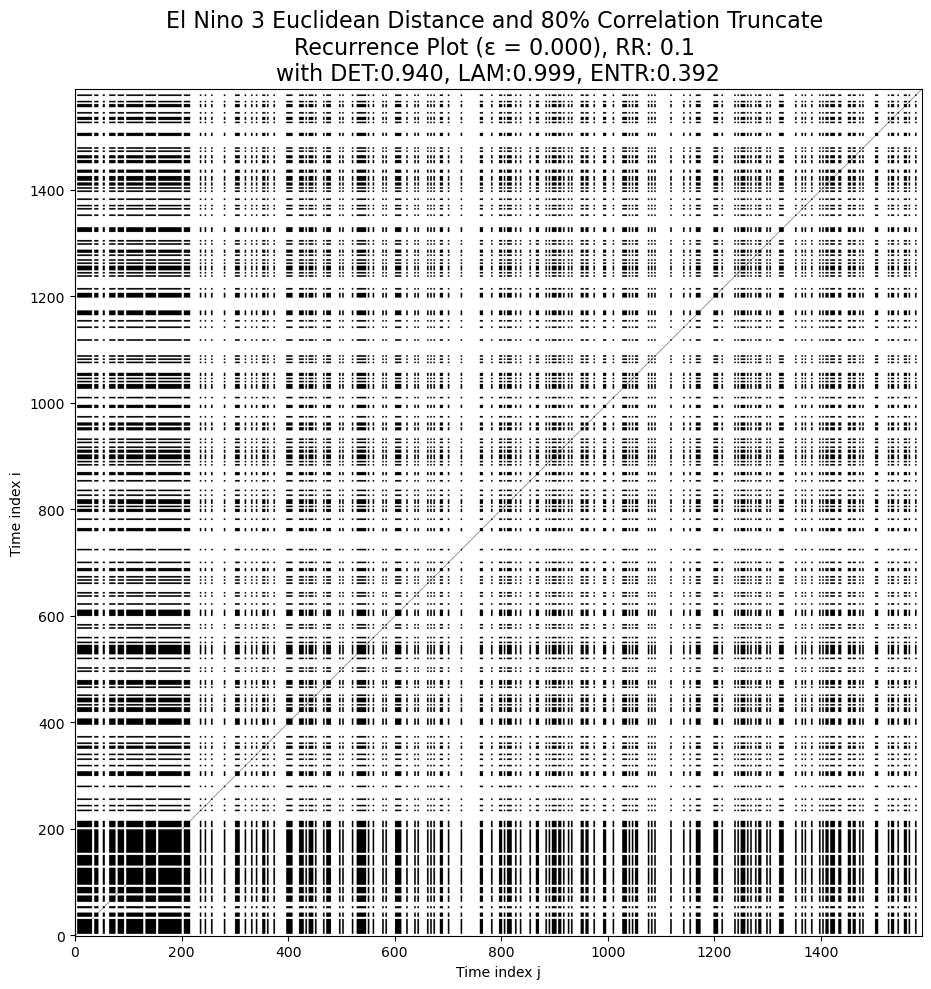

(682, 1590)


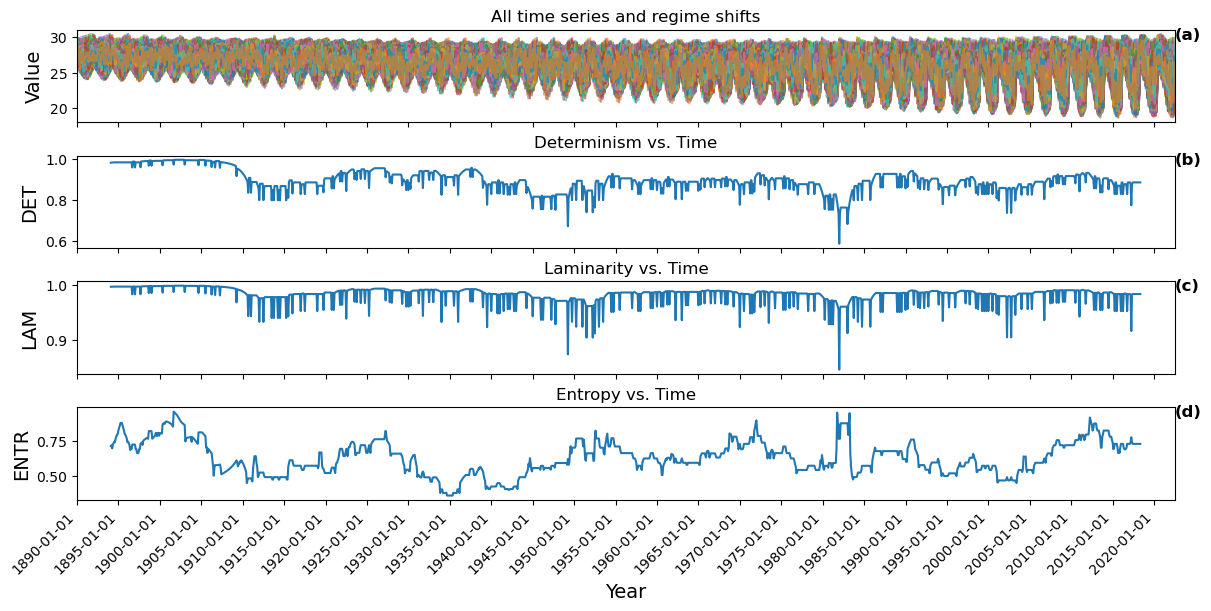

In [13]:
print(sst_raw.shape)
print(lat[84])
print(lon[210])
el_nino_3 = sst_raw[start_time_snapshot:, 84:95 , 208:270] 
print(el_nino_3.shape)
el_nino_3 = el_nino_3.T
el_nino_3 = (el_nino_3.reshape(1590-start_time_snapshot, -1).T)
print(el_nino_3.shape)

sub_dmd = DMD(svd_rank=0.75)
l=9
mrdmd = MrDMD(sub_dmd, max_level=l, max_cycles=1)
mrdmd.fit(el_nino_3)

last_dynamics = mrdmd.partial_dynamics(level=l)
last_modes =  mrdmd.partial_modes(level=l)
last_eigs =  mrdmd.partial_eigs(level=l)
plt.figure(figsize=(25,10))
for i in range(last_dynamics.shape[0]):
    plt.plot(last_dynamics[i])
plt.title(f'Level {l}')
plt.show()

df_dynamics = tr.correlation_truncate(last_dynamics.T, threshold = 0.80)
all_vectors_new = df_dynamics.to_numpy()

print(all_vectors_new.shape)
all_vectors = (all_vectors_new.real)
p=10
plt.figure(figsize=(25,10))
for i in range(all_vectors.shape[1]):
    plt.plot(all_vectors[:,i])
plt.title(f'Level {l}')
plt.show()
metrics = rqa.RecurrencePlot(all_vectors, percent=p, metric ='euclidean', globalEpsilon=True, Title = 'El Nino 3 Euclidean Distance and 80% Correlation Truncate',lines = False)
dt = 1

times, DETS, LAMS, ENTRS = rqa.sliding_window_rqa(
    all_vectors, p, metric='euclidean', q=1,
    window_size=window_size, step=1,
    l_min=2, v_min=2, globalEpsilon=True
)

real_times  = times * dt
total_time  = el_nino_3.shape[1] * dt
time_axis   = np.arange(el_nino_3.shape[1])

fig, axes = plt.subplots(4, 1, sharex=True, figsize=(12, 6), constrained_layout=True)
labels = ['(a)', '(b)', '(c)', '(d)']

print(el_nino_3.shape)
for j in range(el_nino_3.shape[0]):
    axes[0].plot(time_axis, el_nino_3[j], alpha=0.6)
axes[0].set_ylabel('Value', fontsize=14)
axes[0].set_title('All time series and regime shifts', fontsize=12)
axes[0].text(1, 0.9, labels[0], transform=axes[0].transAxes, fontsize=12, fontweight='bold')

axes[1].plot(real_times, DETS, label='DET')
axes[1].set_ylabel('DET', fontsize=14)
axes[1].set_title('Determinism vs. Time', fontsize=12)
axes[1].text(1, 0.9, labels[1], transform=axes[1].transAxes, fontsize=12, fontweight='bold')

axes[2].plot(real_times, LAMS, label='LAM')
axes[2].set_ylabel('LAM', fontsize=14)
axes[2].set_title('Laminarity vs. Time', fontsize=12)
axes[2].text(1, 0.9, labels[2], transform=axes[2].transAxes, fontsize=12, fontweight='bold')

axes[3].plot(real_times, ENTRS, label='ENTR')
axes[3].set_ylabel('ENTR', fontsize=14)
axes[3].set_title('Entropy vs. Time', fontsize=12)
axes[3].text(1, 0.9, labels[3], transform=axes[3].transAxes, fontsize=12, fontweight='bold')

axes[3].set_xlabel('Year', fontsize=14)
axes[3].set_xlim(0, total_time)
axes[3].set_xticks(tick_positions)
axes[3].set_xticklabels([f'{yr}-01-01' for yr in tick_years], rotation=45, ha='right')

plt.show()


(1590, 180, 360)
5.5
210.5
(1590, 11, 51)
(561, 1590)


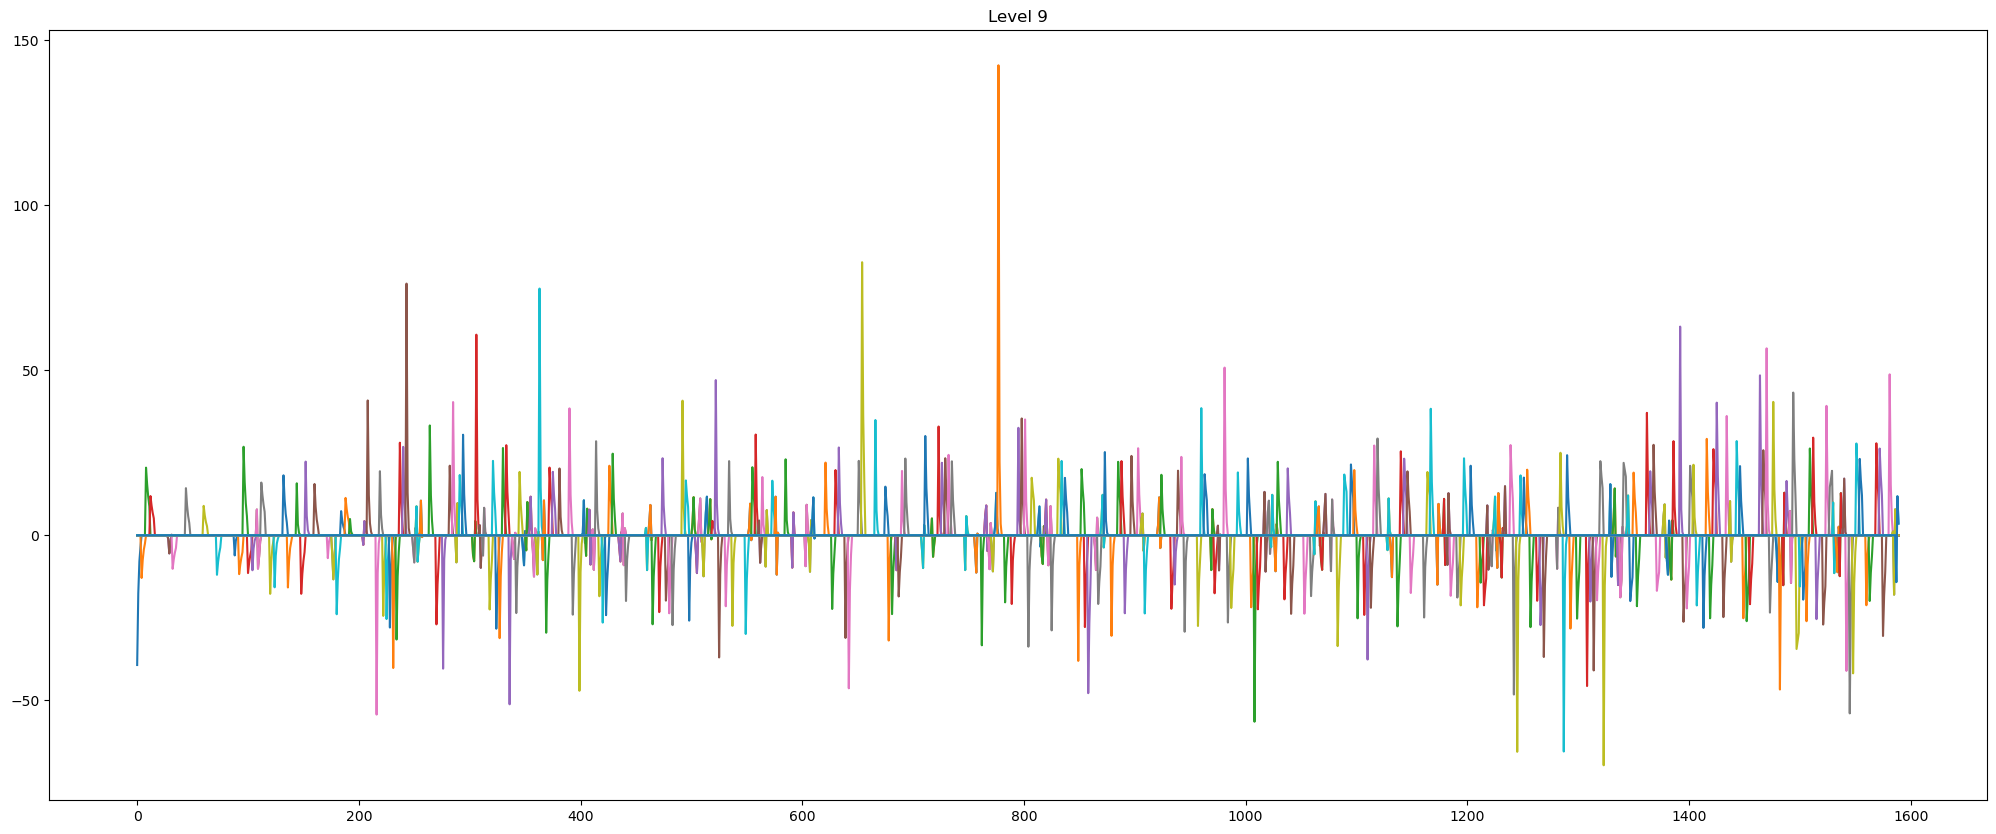

(1590, 363)


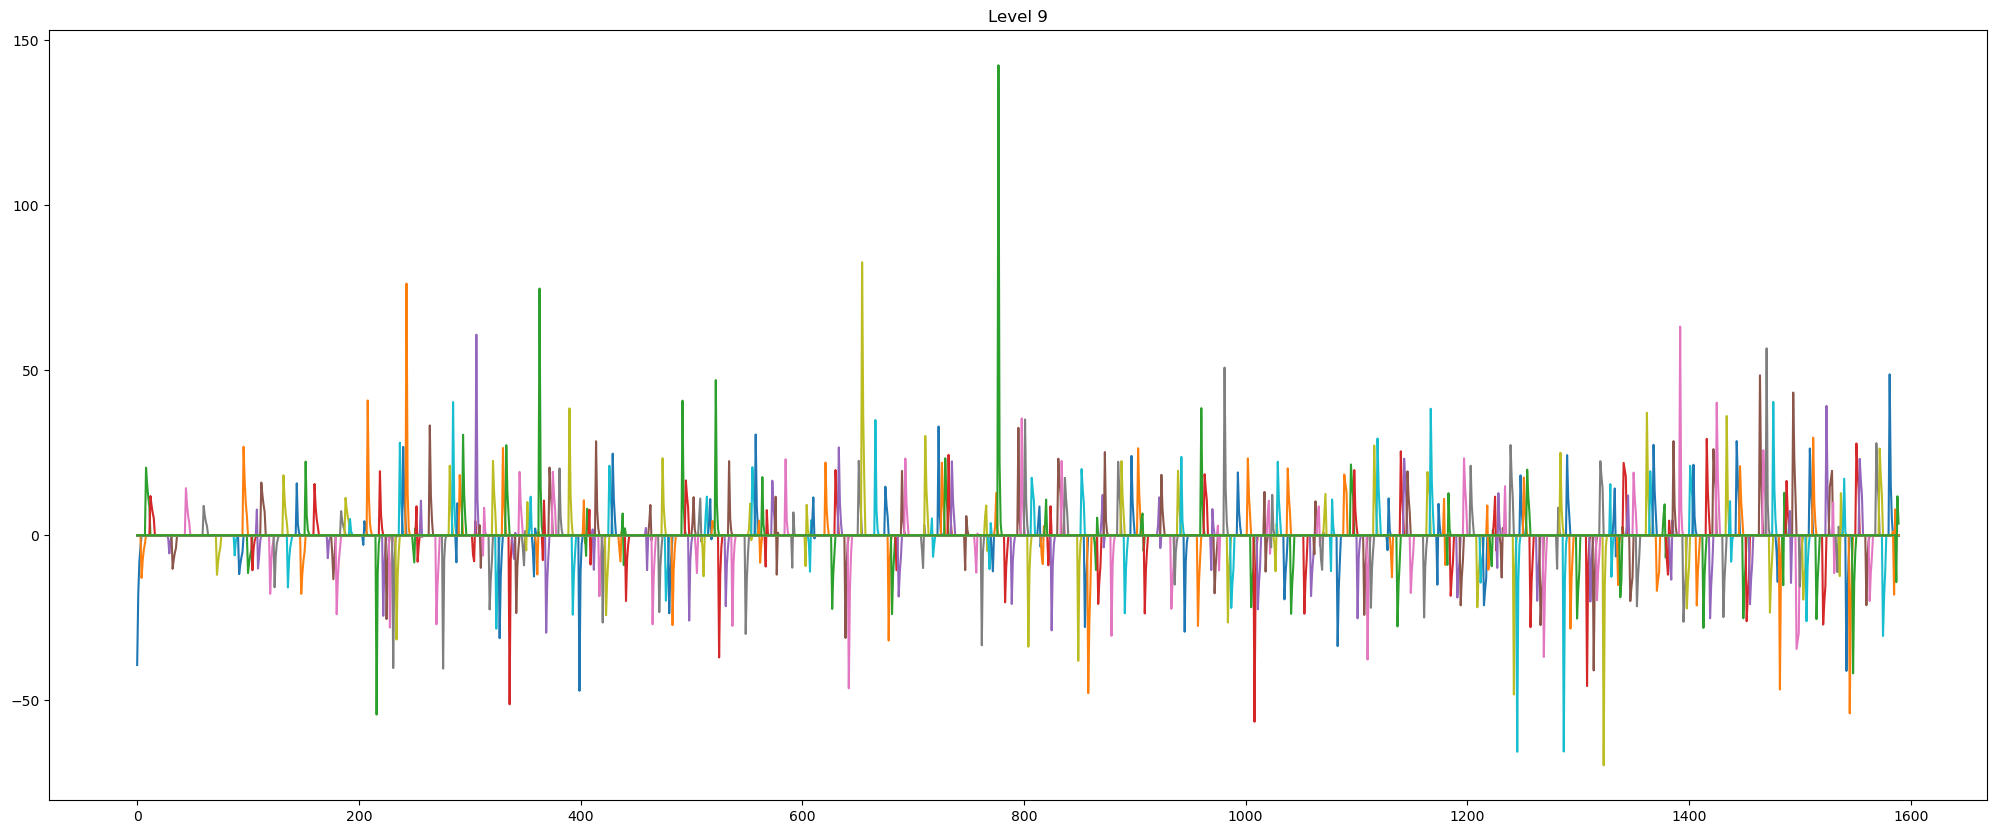

epsilon = 0.605


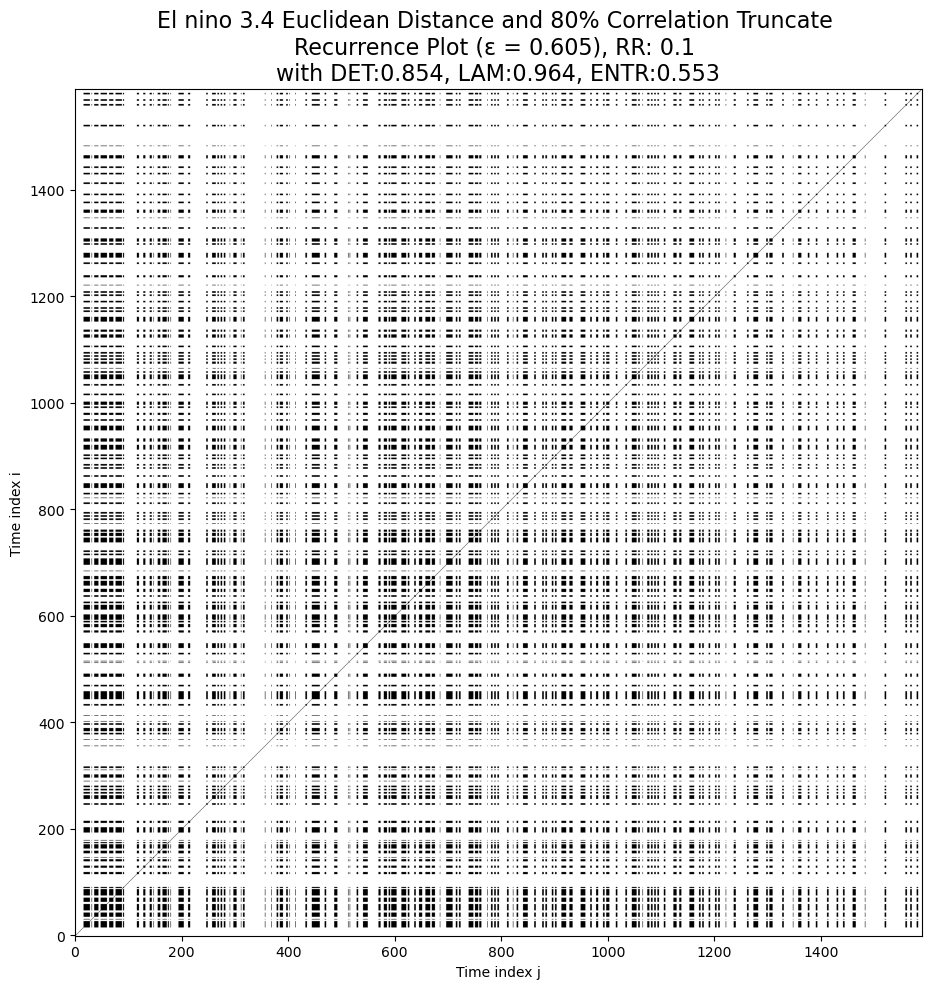

(561, 1590)


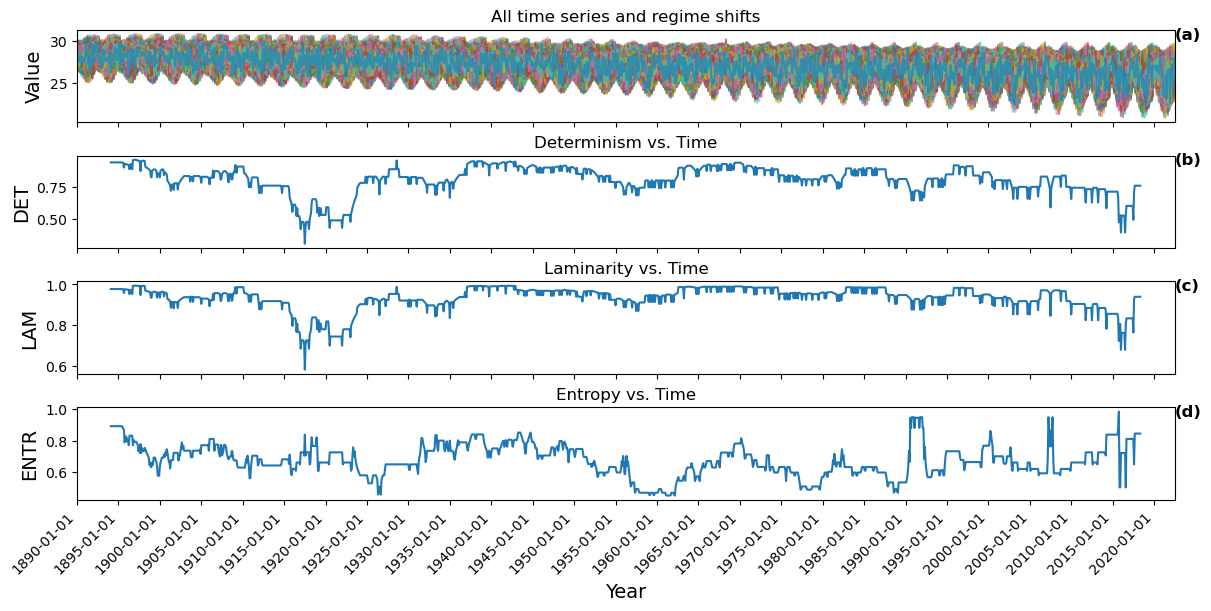

In [14]:
print(sst_raw.shape)
print(lat[84])
print(lon[210])
el_nino_3_4 = sst_raw[start_time_snapshot:, 84:95 , 189:240] 
print(el_nino_3_4.shape)
el_nino_3_4 = el_nino_3_4.T
el_nino_3_4 = (el_nino_3_4.reshape(1590-start_time_snapshot, -1).T)
print(el_nino_3_4.shape)

sub_dmd = DMD(svd_rank=0.75)
l=9
# X = X[:,286:]
mrdmd = MrDMD(sub_dmd, max_level=l, max_cycles=1)
mrdmd.fit(el_nino_3_4)

last_dynamics = mrdmd.partial_dynamics(level=l)
last_modes =  mrdmd.partial_modes(level=l)
last_eigs =  mrdmd.partial_eigs(level=l)
plt.figure(figsize=(25,10))
for i in range(last_dynamics.shape[0]):
    plt.plot(last_dynamics[i])
plt.title(f'Level {l}')
plt.show()

df_dynamics = tr.correlation_truncate(last_dynamics.T, threshold = 0.80)
all_vectors_new = df_dynamics.to_numpy()

print(all_vectors_new.shape)
all_vectors = (all_vectors_new.real)
p=10
plt.figure(figsize=(25,10))
for i in range(all_vectors.shape[1]):
    plt.plot(all_vectors[:,i])
plt.title(f'Level {l}')
plt.show()
metrics = rqa.RecurrencePlot(all_vectors, percent=p, metric ='euclidean', globalEpsilon=True, Title = 'El nino 3.4 Euclidean Distance and 80% Correlation Truncate',lines = False)
dt = 1

times, DETS, LAMS, ENTRS = rqa.sliding_window_rqa(
    all_vectors, p, metric='euclidean', q=1,
    window_size=window_size, step=1,
    l_min=2, v_min=2, globalEpsilon=True
)

real_times  = times * dt
total_time  = el_nino_3_4.shape[1] * dt
time_axis   = np.arange(el_nino_3_4.shape[1])

fig, axes = plt.subplots(4, 1, sharex=True, figsize=(12, 6), constrained_layout=True)
labels = ['(a)', '(b)', '(c)', '(d)']

print(el_nino_3_4.shape)
for j in range(el_nino_3_4.shape[0]):
    axes[0].plot(time_axis, el_nino_3_4[j], alpha=0.6)
axes[0].set_ylabel('Value', fontsize=14)
axes[0].set_title('All time series and regime shifts', fontsize=12)
axes[0].text(1, 0.9, labels[0], transform=axes[0].transAxes, fontsize=12, fontweight='bold')

axes[1].plot(real_times, DETS, label='DET')
axes[1].set_ylabel('DET', fontsize=14)
axes[1].set_title('Determinism vs. Time', fontsize=12)
axes[1].text(1, 0.9, labels[1], transform=axes[1].transAxes, fontsize=12, fontweight='bold')

axes[2].plot(real_times, LAMS, label='LAM')
axes[2].set_ylabel('LAM', fontsize=14)
axes[2].set_title('Laminarity vs. Time', fontsize=12)
axes[2].text(1, 0.9, labels[2], transform=axes[2].transAxes, fontsize=12, fontweight='bold')

axes[3].plot(real_times, ENTRS, label='ENTR')
axes[3].set_ylabel('ENTR', fontsize=14)
axes[3].set_title('Entropy vs. Time', fontsize=12)
axes[3].text(1, 0.9, labels[3], transform=axes[3].transAxes, fontsize=12, fontweight='bold')

axes[3].set_xlabel('Year', fontsize=14)
axes[3].set_xlim(0, total_time)
axes[3].set_xticks(tick_positions)
axes[3].set_xticklabels([f'{yr}-01-01' for yr in tick_years], rotation=45, ha='right')

plt.show()

0.5
5.5
210.5
(1590, 11, 11)
(121, 1590)


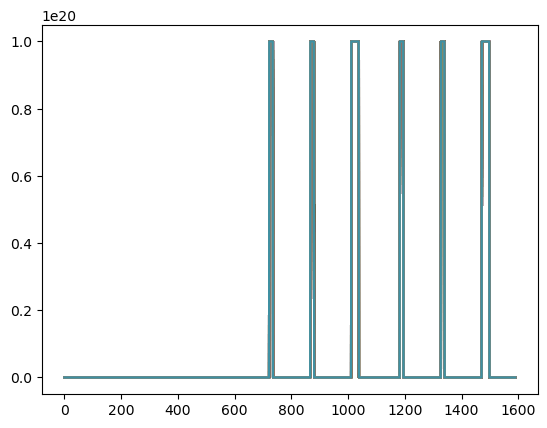

In [15]:
print(lat[89])
print(lat[84])
print(lon[210])
el_nino_1_2 = sst_raw[0:, 79:90 , 269:280] 
print(el_nino_1_2.shape)
el_nino_1_2 = el_nino_1_2.T
el_nino_1_2 = (el_nino_1_2.reshape(1590-0, -1).T)
print(el_nino_1_2.shape)
for i in range(121):
    plt.plot(el_nino_1_2[i], label=f'Spatial Point {i+1}', alpha=0.5)

(1590, 180, 360)


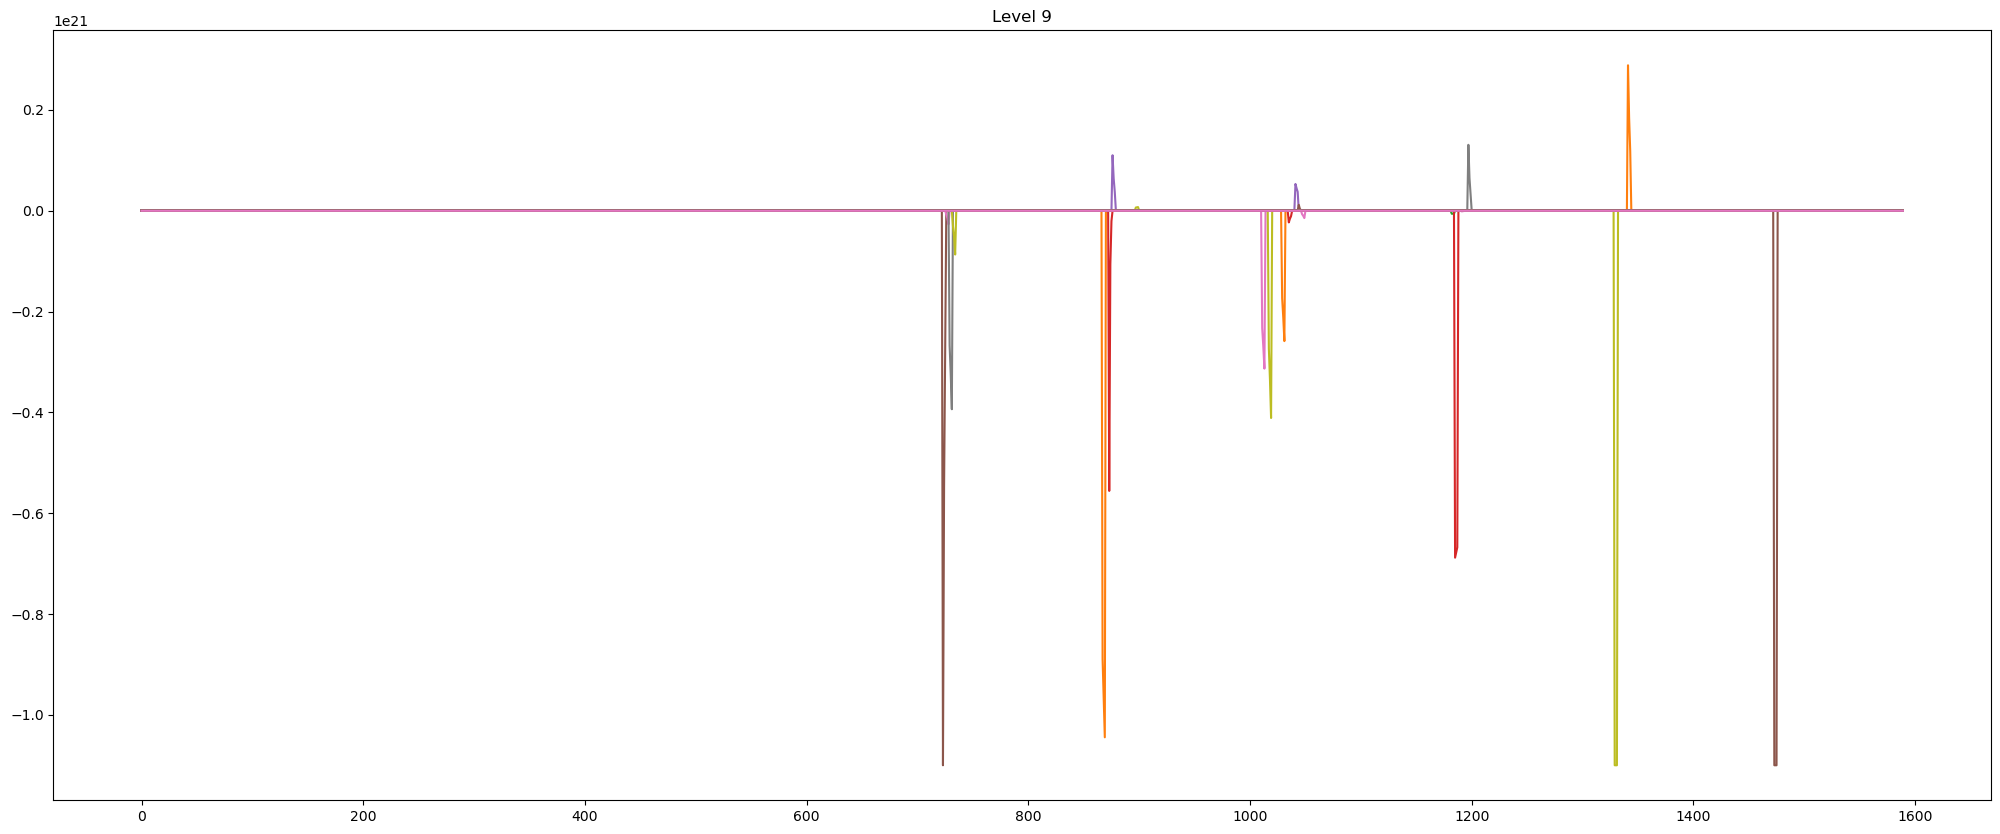

(121, 537)


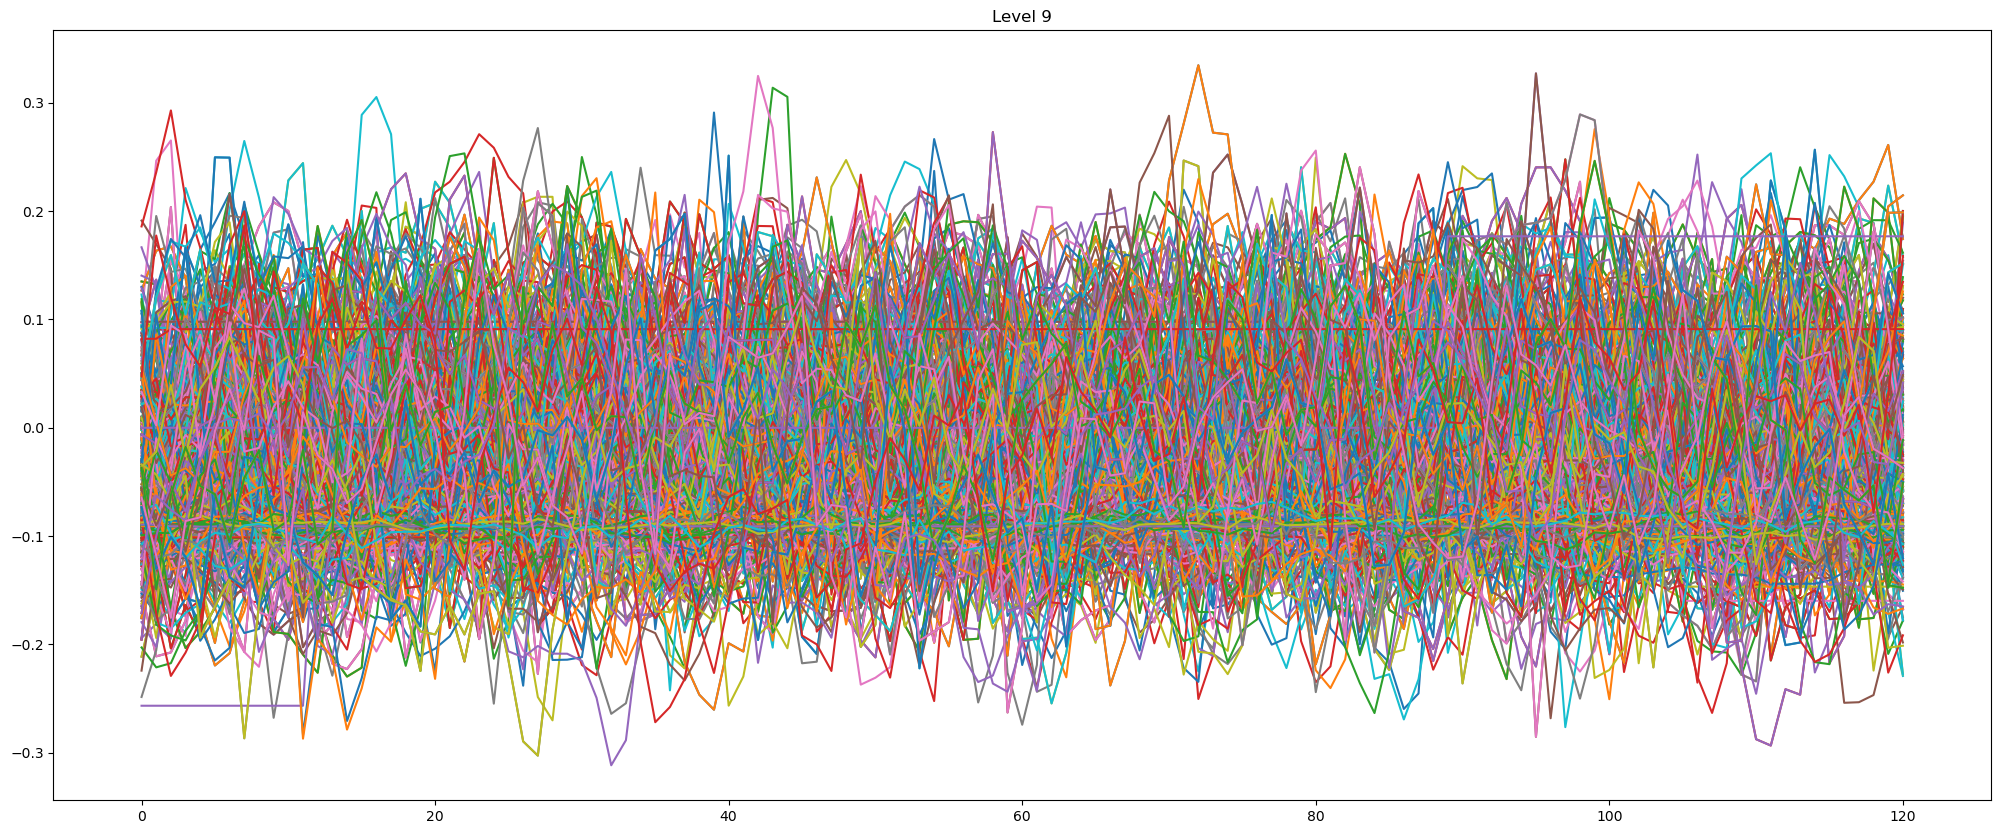

(2.8859254648580814e+20+0j)
(1590, 396)


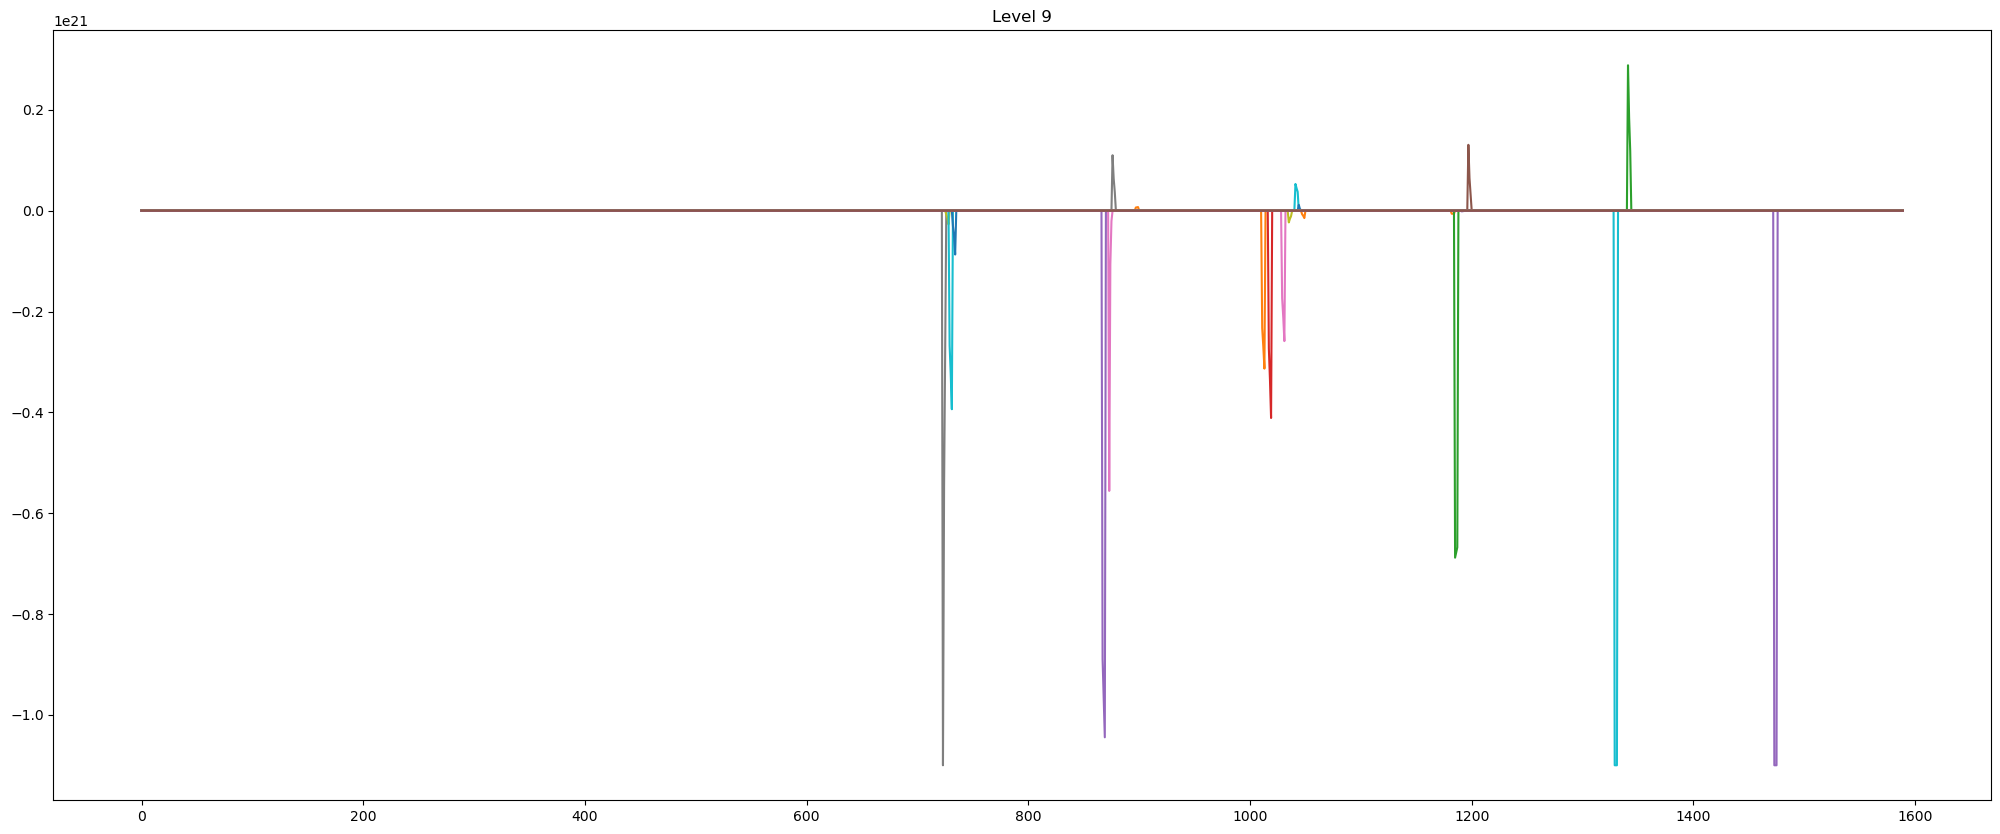

epsilon = 0.431


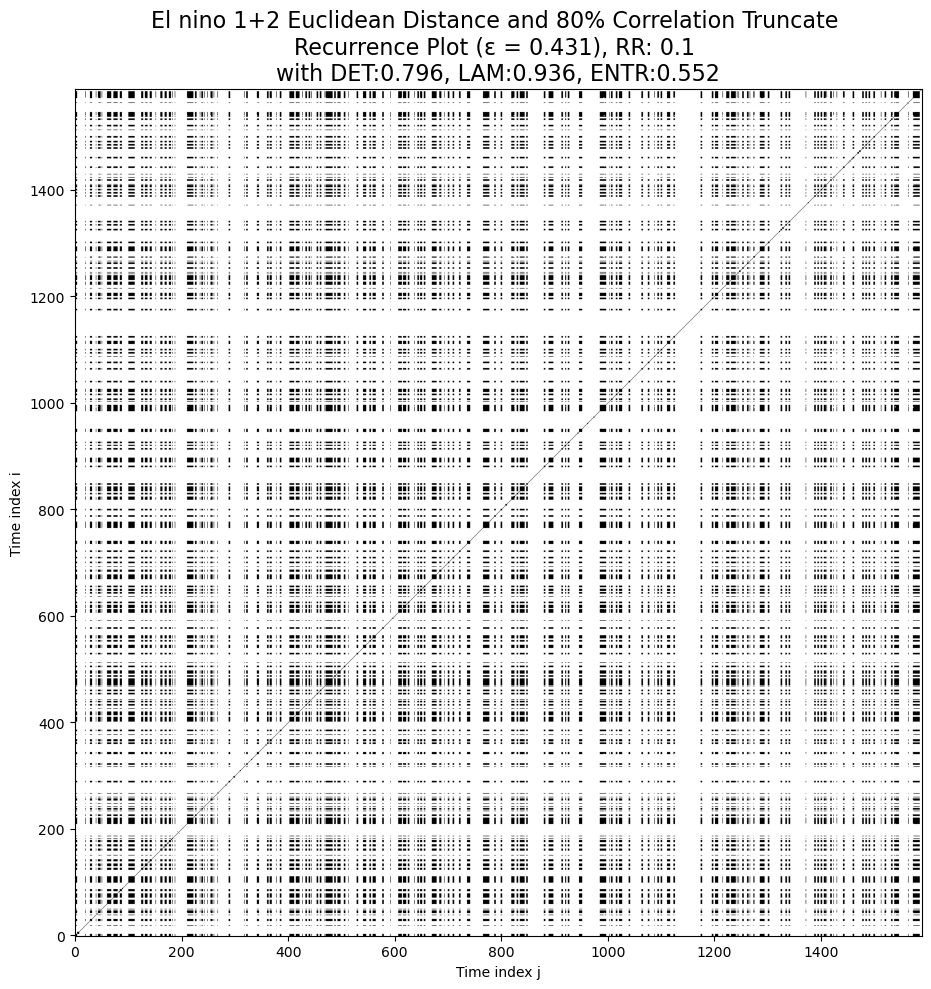

(121, 1590)


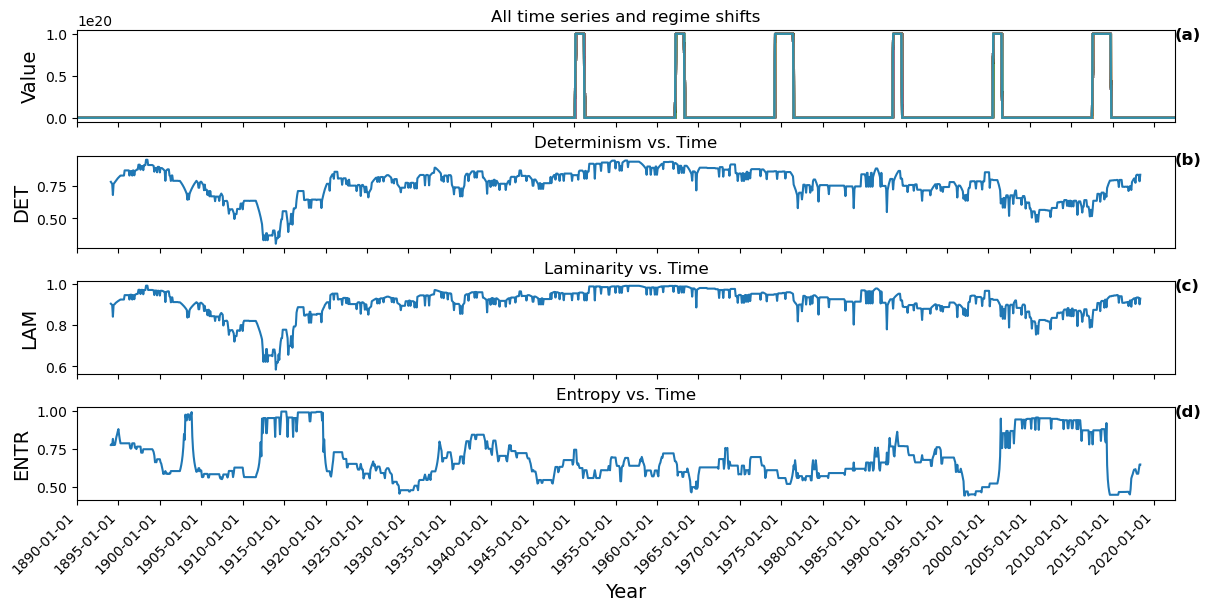

In [16]:
print(sst_raw.shape)


sub_dmd = DMD(svd_rank=0.75)
l=9

mrdmd = MrDMD(sub_dmd, max_level=l, max_cycles=1)
mrdmd.fit(el_nino_1_2)

last_dynamics = mrdmd.partial_dynamics(level=l)
last_modes =  mrdmd.partial_modes(level=l)
last_eigs =  mrdmd.partial_eigs(level=l)
plt.figure(figsize=(25,10))
for i in range(last_dynamics.shape[0]):
    plt.plot(last_dynamics[i])
plt.title(f'Level {l}')
plt.show()

df_dynamics = tr.correlation_truncate(last_dynamics.T, threshold = 0.80)
all_vectors_new = df_dynamics.to_numpy()
print(mrdmd.partial_modes(level=l).shape)

plt.figure(figsize=(25,10))
for i in range(mrdmd.partial_modes(level=l).shape[1]):
    plt.plot(mrdmd.partial_modes(level=l)[:,i])
plt.title(f'Level {l}')
plt.show()

print(np.max(last_dynamics))

print(all_vectors_new.shape)
all_vectors = (all_vectors_new.real)
p=10
plt.figure(figsize=(25,10))
for i in range(all_vectors.shape[1]):
    plt.plot(all_vectors[:,i])
plt.title(f'Level {l}')
plt.show()

metrics = rqa.RecurrencePlot(all_vectors, percent=p, metric ='euclidean', globalEpsilon=True, Title = 'El nino 1+2 Euclidean Distance and 80% Correlation Truncate',lines = False)
dt = 1
times, DETS, LAMS, ENTRS = rqa.sliding_window_rqa(
    all_vectors, p, metric='euclidean', q=1,
    window_size=window_size, step=1,
    l_min=2, v_min=2, globalEpsilon=True
)

real_times  = times * dt
total_time  = el_nino_1_2.shape[1] * dt
time_axis   = np.arange(el_nino_1_2.shape[1])

fig, axes = plt.subplots(4, 1, sharex=True, figsize=(12, 6), constrained_layout=True)
labels = ['(a)', '(b)', '(c)', '(d)']

print(el_nino_1_2.shape)
for j in range(el_nino_1_2.shape[0]):
    axes[0].plot(time_axis, el_nino_1_2[j], alpha=0.6)
axes[0].set_ylabel('Value', fontsize=14)
axes[0].set_title('All time series and regime shifts', fontsize=12)
axes[0].text(1, 0.9, labels[0], transform=axes[0].transAxes, fontsize=12, fontweight='bold')

axes[1].plot(real_times, DETS, label='DET')
axes[1].set_ylabel('DET', fontsize=14)
axes[1].set_title('Determinism vs. Time', fontsize=12)
axes[1].text(1, 0.9, labels[1], transform=axes[1].transAxes, fontsize=12, fontweight='bold')

axes[2].plot(real_times, LAMS, label='LAM')
axes[2].set_ylabel('LAM', fontsize=14)
axes[2].set_title('Laminarity vs. Time', fontsize=12)
axes[2].text(1, 0.9, labels[2], transform=axes[2].transAxes, fontsize=12, fontweight='bold')

axes[3].plot(real_times, ENTRS, label='ENTR')
axes[3].set_ylabel('ENTR', fontsize=14)
axes[3].set_title('Entropy vs. Time', fontsize=12)
axes[3].text(1, 0.9, labels[3], transform=axes[3].transAxes, fontsize=12, fontweight='bold')

axes[3].set_xlabel('Year', fontsize=14)
axes[3].set_xlim(0, total_time)
axes[3].set_xticks(tick_positions)
axes[3].set_xticklabels([f'{yr}-01-01' for yr in tick_years], rotation=45, ha='right')

plt.show()

(1590, 121)


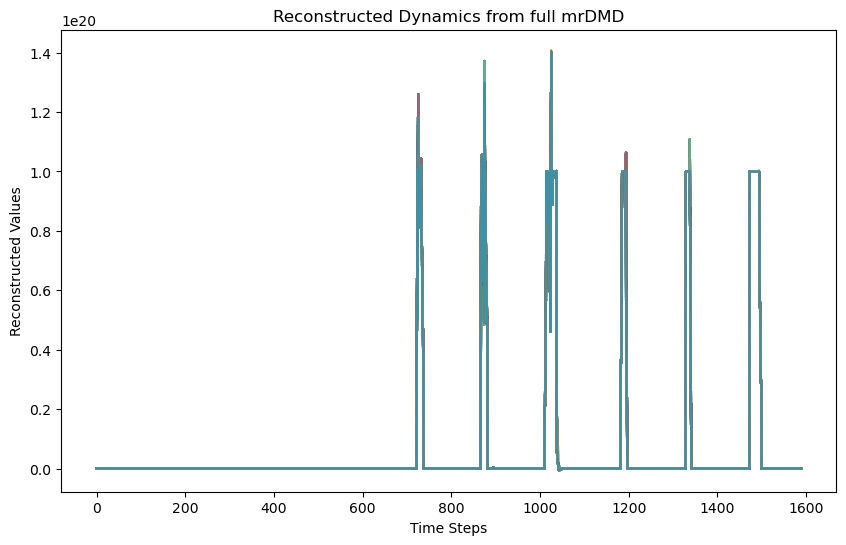

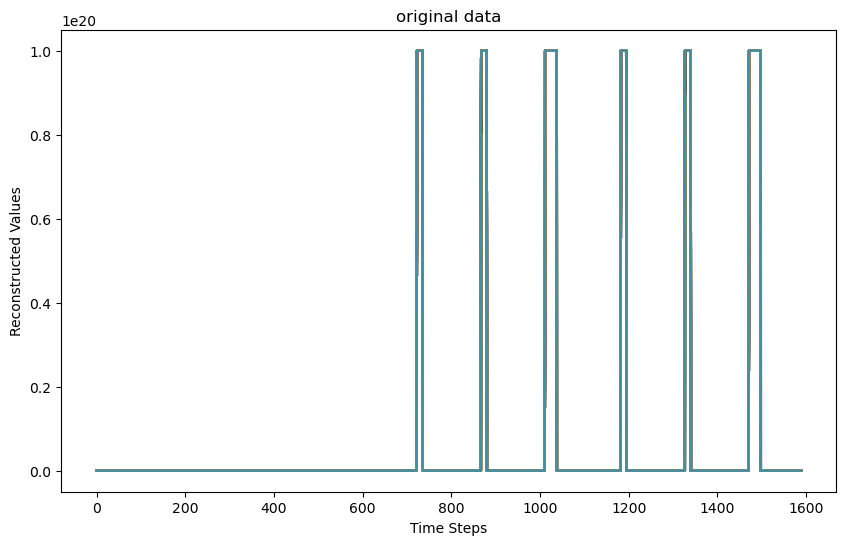

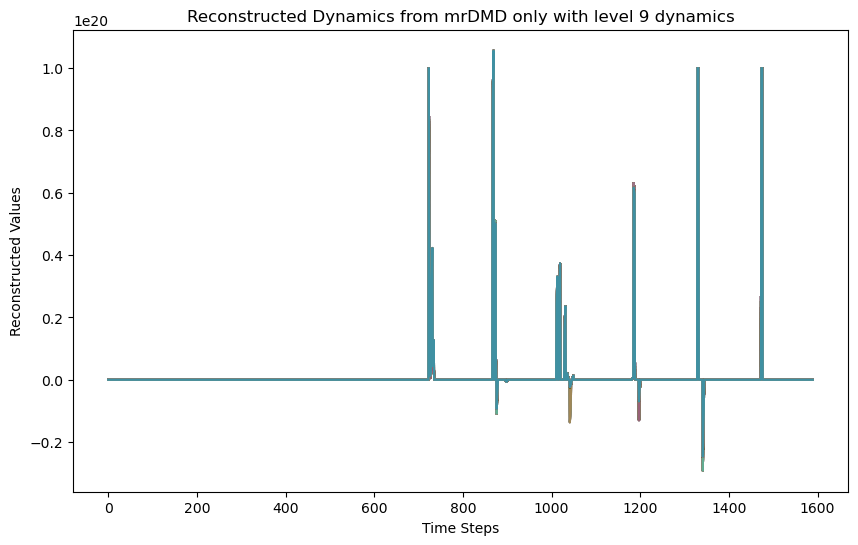

In [17]:
recon = mrdmd.reconstructed_data.T
recon_2 = (mrdmd.partial_modes(level=l) @ mrdmd.partial_dynamics(level=l)).T
print(recon.shape)
plt.figure(figsize=(10, 6))
plt.plot(recon, alpha=0.5)
plt.title('Reconstructed Dynamics from full mrDMD')
plt.xlabel('Time Steps')
plt.ylabel('Reconstructed Values')
plt.show()
plt.figure(figsize=(10, 6))
plt.plot(el_nino_1_2.T, alpha=0.5)
plt.title('original data')
plt.xlabel('Time Steps')
plt.ylabel('Reconstructed Values')
plt.show()
plt.figure(figsize=(10, 6))
plt.plot(recon_2, alpha=0.5)
plt.title(f'Reconstructed Dynamics from mrDMD only with level {l} dynamics')
plt.xlabel('Time Steps')
plt.ylabel('Reconstructed Values')
plt.show()
